In [1]:
import math
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

In [2]:
event = pd.read_excel('Events & Trust.xlsx') 
event['reported_date'] = pd.to_datetime(event['reported_date'].astype('str'),format='%Y-%m-%d', errors='coerce')
event['effective_date'] = pd.to_datetime(event['effective_date'].astype('str'),format='%Y-%m-%d', errors='coerce')
event = event[(event.reported_date.notna())&(event.effective_date.notna())].reset_index(drop=True)

In [3]:
event # Event date for each SPAC

,spac_id,code,reported_date,effective_date,trust_date,trust_per_share,shares_outstanding,state_type_id
0,1,REGISTERED,2018-05-29,2018-05-29,NaT,NaN,NaN,1.0
1,1,IPO,2018-07-03,2018-07-03,NaT,NaN,NaN,2.0
2,1,TRUST,2018-07-03,2018-07-03,2020-01-03,10.000,13000000.0,NaN
3,1,TRUST,2018-07-06,2018-07-06,2020-01-03,10.000,14950000.0,NaN
4,1,TRUST,2018-11-14,2018-09-30,2020-01-03,10.045,14950000.0,NaN
...,...,...,...,...,...,...,...,...
10622,1586,TRUST,2022-12-31,2022-12-31,2023-12-31,10.000,6000000.0,NaN
10623,1586,IPO,2022-12-31,2022-12-31,NaT,NaN,NaN,2.0
10624,1587,TRUST,2022-03-28,2022-03-28,2023-08-03,10.175,18500000.0,NaN
10625,1587,REGISTERED,2022-03-28,2022-03-28,NaT,NaN,NaN,1.0


In [4]:
header = pd.read_excel('Header.xlsx', sheet_name='main')  

In [5]:
header # Industry, sponsor, trust bank etc. of each SPAC

,spac_id,offering_id,sponsor_id,name,industry_type_id,bulldog,trust_bank_id,trust_country_ref_id
0,1,NaN,NaN,Allegro Merger Corp,5,NaN,NaN,NaN
1,2,NaN,NaN,Atlantic Acquisition Corp,5,NaN,NaN,NaN
2,3,NaN,NaN,Avista Healthcare Public Acquisition Corp.,6,NaN,NaN,NaN
3,4,NaN,NaN,Barington/Hilco Acquisition Corp.,7,NaN,NaN,NaN
4,5,NaN,NaN,Big Rock Partners Acquisition,8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1567,1583,NaN,1067.0,Zi Toprun Acquisition Corp.,227,0.15,1.0,19906.0
1568,1584,NaN,1068.0,ClimateRock,81,0.15,1.0,19906.0
1569,1585,NaN,1069.0,Hudson Acquisition I Corp.,5,0.15,1.0,19906.0
1570,1586,NaN,1070.0,Bellevue Life Sciences Acquisition Corp.,6,0.15,1.0,19906.0


In [6]:
info_warrant = pd.read_excel('Security Info.xlsx', sheet_name='warrant')  
info_equity = pd.read_excel('Security Info.xlsx', sheet_name='equity') 
info_right = pd.read_excel('Security Info.xlsx', sheet_name='right') 

In [7]:
info_warrant = info_warrant.rename(columns = {'per_unit':'warrant_per_unit','conversion_ratio':'warrant_conversion_ratio'})
info_equity = info_equity.rename(columns = {'per_unit':'equity_per_unit'})
info_right = info_right.rename(columns = {'per_unit':'right_per_unit','conversion_ratio':'right_conversion_ratio'})

In [8]:
info_spac = info_warrant.merge(info_equity,how='outer', on=['spac_id'])
info_spac = info_spac.merge(info_right,how='outer', on=['spac_id'])

In [9]:
info_spac = info_spac.sort_values(by=['spac_id']).reset_index(drop=True)
info_spac = info_spac[info_spac.warrant_per_unit.notna()].reset_index(drop=True)

In [10]:
info_spac # basic information of security

,spac_id,warrant_per_unit,warrant_conversion_ratio,strike_price,duration,redemption_price,equity_per_unit,right_per_unit,right_conversion_ratio
0,1,1.0,1.0,11.5,5.0,18.0,1,1.0,0.1
1,3,1.0,0.5,11.5,5.0,24.0,1,NaN,NaN
2,4,1.0,0.5,12.5,3.0,17.5,1,1.0,0.1
3,5,0.5,1.0,11.5,5.0,21.0,1,1.0,0.1
4,6,0.5,1.0,11.5,5.0,24.0,1,1.0,0.1
...,...,...,...,...,...,...,...,...,...
1496,1595,1.0,1.0,11.5,5.0,18.0,1,NaN,NaN
1497,1596,0.5,1.0,11.5,5.0,18.0,1,NaN,NaN
1498,1597,0.5,1.0,11.5,5.0,18.0,1,NaN,NaN
1499,1598,1.0,1.0,11.5,5.0,18.0,1,1.0,0.1


In [11]:
price = pd.read_excel('Security prices.xlsx')
price

,spac_id,date,unit,equity,warrant,rights
0,1,2018-07-03,10.05,NaN,NaN,NaN
1,1,2018-07-04,10.05,NaN,NaN,NaN
2,1,2018-07-05,10.04,NaN,NaN,NaN
3,1,2018-07-06,10.06,NaN,NaN,NaN
4,1,2018-07-09,10.06,NaN,NaN,NaN
...,...,...,...,...,...,...
559231,1580,2022-04-27,10.04,NaN,NaN,NaN
559232,1580,2022-04-28,10.03,NaN,NaN,NaN
559233,1580,2022-04-29,10.04,NaN,NaN,NaN
559234,1584,2022-04-28,10.06,NaN,NaN,NaN


In [12]:
price = price.dropna(how='all',subset=['unit', 'equity','warrant','rights']).reset_index(drop=True)
price = price.merge(info_spac[['spac_id','warrant_conversion_ratio','strike_price','redemption_price']],how='left',on='spac_id')
price

,spac_id,date,unit,equity,warrant,rights,warrant_conversion_ratio,strike_price,redemption_price
0,1,2018-07-03,10.05,NaN,NaN,NaN,1.0,11.5,18.0
1,1,2018-07-04,10.05,NaN,NaN,NaN,1.0,11.5,18.0
2,1,2018-07-05,10.04,NaN,NaN,NaN,1.0,11.5,18.0
3,1,2018-07-06,10.06,NaN,NaN,NaN,1.0,11.5,18.0
4,1,2018-07-09,10.06,NaN,NaN,NaN,1.0,11.5,18.0
...,...,...,...,...,...,...,...,...,...
506581,1580,2022-04-27,10.04,NaN,NaN,NaN,1.0,11.5,16.5
506582,1580,2022-04-28,10.03,NaN,NaN,NaN,1.0,11.5,16.5
506583,1580,2022-04-29,10.04,NaN,NaN,NaN,1.0,11.5,16.5
506584,1584,2022-04-28,10.06,NaN,NaN,NaN,1.0,11.5,18.0


In [13]:
# exclude equity prices larger than 30, based on expeirence and 3 times std criteria
price = price.fillna(0)
price = price[price.equity <= 30]

In [14]:
# exclude warrant prices that are larger than than the equity it can buy
price = price[price.warrant <= price.equity*price.warrant_conversion_ratio]

In [15]:
# exclude irrational warrant price: warrant price<intrinsic value
price['intrinsic_value'] = (price.equity - price.strike_price)*price.warrant_conversion_ratio
price = price[price.warrant >= price.intrinsic_value]

In [16]:
# exclude the equities that exist less than three months
price = price[(price.equity != 0)]
price['data_period'] = price.groupby('spac_id')['date'].transform('count')
price = price[price['data_period'] > 3*21].reset_index(drop=True)

In [17]:
price

,spac_id,date,unit,equity,warrant,rights,warrant_conversion_ratio,strike_price,redemption_price,intrinsic_value,data_period
0,1,2018-08-15,10.25,9.53,0.3600,0.4000,1.0,11.5,18.0,-1.97,437
1,1,2018-08-16,10.22,9.52,0.3600,0.4000,1.0,11.5,18.0,-1.98,437
2,1,2018-08-17,0.00,9.53,0.3600,0.4220,1.0,11.5,18.0,-1.97,437
3,1,2018-08-20,0.00,9.52,0.3401,0.4300,1.0,11.5,18.0,-1.98,437
4,1,2018-08-21,0.00,9.54,0.3400,0.4100,1.0,11.5,18.0,-1.96,437
...,...,...,...,...,...,...,...,...,...,...,...
291897,1503,2022-04-25,0.00,9.88,0.1806,0.1474,1.0,11.5,18.0,-1.62,68
291898,1503,2022-04-26,0.00,9.88,0.1650,0.1500,1.0,11.5,18.0,-1.62,68
291899,1503,2022-04-27,0.00,9.91,0.2000,0.1475,1.0,11.5,18.0,-1.59,68
291900,1503,2022-04-28,0.00,9.91,0.1826,0.1475,1.0,11.5,18.0,-1.59,68


In [18]:
# exclude the SPAC with irrational strike price
info_spac[info_spac.strike_price>20]

,spac_id,warrant_per_unit,warrant_conversion_ratio,strike_price,duration,redemption_price,equity_per_unit,right_per_unit,right_conversion_ratio
8,10,0.500000,0.25,23.00,5.0,36.0,1,1.0,0.1
24,26,1.000000,1.00,92.00,5.0,21.0,1,1.0,0.1
228,244,0.111111,1.00,23.00,5.0,36.0,1,NaN,NaN
285,306,0.250000,1.00,27.50,5.0,45.0,1,NaN,NaN
402,426,0.250000,1.00,28.75,5.0,45.0,1,NaN,NaN


In [19]:
price = price[price.strike_price<=30]

In [20]:
# exclude the spacs with irrational redemption price 
info_spac[info_spac.redemption_price<info_spac.strike_price]

,spac_id,warrant_per_unit,warrant_conversion_ratio,strike_price,duration,redemption_price,equity_per_unit,right_per_unit,right_conversion_ratio
24,26,1.000000,1.0,92.0,5.0,21.0,1,1.0,0.1
217,233,0.333333,1.0,11.5,18.0,5.0,1,NaN,NaN
661,693,5.000000,1.0,5.0,7.0,0.0,1,NaN,NaN
662,693,5.000000,1.0,5.0,7.0,0.0,1,NaN,NaN
1066,1123,0.500000,0.5,11.5,5.0,5.0,1,NaN,NaN


In [21]:
# redemption price should be larger than strike price
price = price[price.redemption_price>=price.strike_price].reset_index(drop=True)

In [22]:
price

,spac_id,date,unit,equity,warrant,rights,warrant_conversion_ratio,strike_price,redemption_price,intrinsic_value,data_period
0,1,2018-08-15,10.25,9.53,0.3600,0.4000,1.0,11.5,18.0,-1.97,437
1,1,2018-08-16,10.22,9.52,0.3600,0.4000,1.0,11.5,18.0,-1.98,437
2,1,2018-08-17,0.00,9.53,0.3600,0.4220,1.0,11.5,18.0,-1.97,437
3,1,2018-08-20,0.00,9.52,0.3401,0.4300,1.0,11.5,18.0,-1.98,437
4,1,2018-08-21,0.00,9.54,0.3400,0.4100,1.0,11.5,18.0,-1.96,437
...,...,...,...,...,...,...,...,...,...,...,...
290834,1503,2022-04-25,0.00,9.88,0.1806,0.1474,1.0,11.5,18.0,-1.62,68
290835,1503,2022-04-26,0.00,9.88,0.1650,0.1500,1.0,11.5,18.0,-1.62,68
290836,1503,2022-04-27,0.00,9.91,0.2000,0.1475,1.0,11.5,18.0,-1.59,68
290837,1503,2022-04-28,0.00,9.91,0.1826,0.1475,1.0,11.5,18.0,-1.59,68


In [23]:
price_warrant = price[['spac_id','date','equity','warrant']]
price_warrant = price_warrant[price_warrant.warrant != 0] # drop zeros in warrant prices
price_warrant = price_warrant.drop_duplicates(subset=['spac_id', 'date'], keep='last').reset_index(drop=True) # drop duplicate
price_warrant # warrant prices and equity prices

,spac_id,date,equity,warrant
0,1,2018-08-15,9.53,0.3600
1,1,2018-08-16,9.52,0.3600
2,1,2018-08-17,9.53,0.3600
3,1,2018-08-20,9.52,0.3401
4,1,2018-08-21,9.54,0.3400
...,...,...,...,...
147764,1503,2022-04-25,9.88,0.1806
147765,1503,2022-04-26,9.88,0.1650
147766,1503,2022-04-27,9.91,0.2000
147767,1503,2022-04-28,9.91,0.1826


# Risk-free rate

In [24]:
# 10-yr treasury bond rate
rf = pd.read_csv('risk_free.csv').dropna().reset_index(drop=True)
rf['date'] = pd.to_datetime(rf['DATE'].astype('str'),format='%Y-%m-%d')
rf['rf_rate'] = pd.to_numeric(rf['DGS10'],errors='coerce')/100
rf

,DATE,DGS10,date,rf_rate
0,2018-01-02,2.46,2018-01-02,0.0246
1,2018-01-03,2.44,2018-01-03,0.0244
2,2018-01-04,2.46,2018-01-04,0.0246
3,2018-01-05,2.47,2018-01-05,0.0247
4,2018-01-08,2.49,2018-01-08,0.0249
...,...,...,...,...
1229,2022-09-19,3.49,2022-09-19,0.0349
1230,2022-09-20,3.57,2022-09-20,0.0357
1231,2022-09-21,3.51,2022-09-21,0.0351
1232,2022-09-22,3.70,2022-09-22,0.0370


# Volatility

## 1) constant volatility during the whole period 

In [25]:
price_warrant['equity_ret'] = price_warrant.groupby('spac_id')['equity'].pct_change()

In [26]:
# volatility of equity
vol_equity = price_warrant.groupby(by='spac_id')['equity_ret'].std() * np.sqrt(252)
vol_equity = vol_equity.dropna().reset_index()
vol_equity.columns = 'spac_id','volatility'
vol_equity

,spac_id,volatility
0,1,0.169515
1,3,0.528089
2,4,0.253410
3,5,0.484824
4,6,4.049434
...,...,...
619,1429,0.034391
620,1435,0.028945
621,1459,0.028232
622,1485,0.016210


In [27]:
pricing = price_warrant.merge(info_spac[['spac_id','strike_price','duration','redemption_price',
                                         'warrant_per_unit','warrant_conversion_ratio']],on='spac_id',how='left')
pricing = pricing.merge(rf[['date','rf_rate']],on='date',how='left').merge(vol_equity,on='spac_id',how='left')

In [28]:
# volatility of S+M/N*W
pricing['adj_S'] = pricing['equity'] + pricing['warrant_per_unit']*pricing['warrant_conversion_ratio']*pricing['warrant']
pricing['adj_ret'] = pricing['adj_S'].pct_change()

In [29]:
adjust_vol_equity = pricing.groupby(by='spac_id')['adj_ret'].std() * np.sqrt(252)
adjust_vol_equity = adjust_vol_equity.dropna().reset_index()
adjust_vol_equity.columns = 'spac_id','adj_vol'
adjust_vol_equity

,spac_id,adj_vol
0,1,0.172069
1,3,0.520212
2,4,0.864837
3,5,0.515172
4,6,3.981611
...,...,...
621,1429,0.039120
622,1435,0.040009
623,1459,0.030992
624,1485,0.050666


In [30]:
pricing = pricing.merge(adjust_vol_equity,on='spac_id',how='left')

In [31]:
# TTM
split_date = pd.read_excel('Clean_Split_Date.xlsx')
split_date['Split Date'] = pd.to_datetime(split_date['Split Date'].astype('str'),format='%Y-%m-%d', errors='coerce')
split_date = split_date.dropna(subset=['Split Date']).reset_index(drop=True)
split_date

,Spac Id,Symbol,Name,IPO date,CIK lookup,Split Date,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,ALGR,Allegro Merger Corp,2018-07-03,1720025,2018-08-13,NaN,NaN,NaN
1,2,ATAC,Atlantic Acquisition Corp,2017-08-09,1680873,2017-09-07,NaN,NaN,NaN
2,3,AHPA,Avista Healthcare Public Acquisition Corp.,2016-10-11,1661181,2016-11-29,NaN,NaN,NaN
3,4,BHAC,Barington/Hilco Acquisition Corp.,2015-02-06,1622175,2015-03-06,NaN,NaN,NaN
4,5,BRPA,Big Rock Partners Acquisition,2017-11-20,1719406,2017-12-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1075,1565,DECA,Denali Capital Acquisition Corp,2022-04-07,1913577,2022-05-31,NaN,NaN,NaN
1076,1568,MSSA,Metal Sky Star Acquisition Corporation,2022-03-31,1882464,2022-05-31,NaN,NaN,NaN
1077,1570,AFAR,Aura FAT Projects Acquisition Corp,2022-04-13,1901886,2022-06-03,NaN,NaN,NaN
1078,1584,CLRC,ClimateRock,2022-04-28,1903392,2022-06-02,NaN,NaN,NaN


In [32]:
pricing = pricing.merge(split_date[['Spac Id','Split Date']],left_on='spac_id',right_on='Spac Id',how='left')
pricing = pricing.dropna().drop(['Spac Id'],axis=1).reset_index(drop=True)

In [33]:
pricing['delta_t'] = (pricing['date']-pricing['Split Date']).dt.days / 360
pricing['TTM'] = pricing['duration'] - pricing['delta_t']

In [34]:
# adjust equity price upon exercise
pricing['adj_equity'] = ((pricing['equity']+
                          pricing['warrant_per_unit']*pricing['warrant_conversion_ratio']*pricing['strike_price'])/ 
                         (1+pricing['warrant_per_unit']*pricing['warrant_conversion_ratio']))

In [35]:
pricing

,spac_id,date,equity,warrant,equity_ret,strike_price,duration,redemption_price,warrant_per_unit,warrant_conversion_ratio,rf_rate,volatility,adj_S,adj_ret,adj_vol,Split Date,delta_t,TTM,adj_equity
0,1,2018-08-16,9.52,0.3600,-0.001049,11.5,5.0,18.0,1.0,1.0,0.0287,0.169515,9.88000,-0.001011,0.172069,2018-08-13,0.008333,4.991667,10.510000
1,1,2018-08-17,9.53,0.3600,0.001050,11.5,5.0,18.0,1.0,1.0,0.0287,0.169515,9.89000,0.001012,0.172069,2018-08-13,0.011111,4.988889,10.515000
2,1,2018-08-20,9.52,0.3401,-0.001049,11.5,5.0,18.0,1.0,1.0,0.0282,0.169515,9.86010,-0.003023,0.172069,2018-08-13,0.019444,4.980556,10.510000
3,1,2018-08-21,9.54,0.3400,0.002101,11.5,5.0,18.0,1.0,1.0,0.0285,0.169515,9.88000,0.002018,0.172069,2018-08-13,0.022222,4.977778,10.520000
4,1,2018-08-22,9.54,0.3200,0.000000,11.5,5.0,18.0,1.0,1.0,0.0282,0.169515,9.86000,-0.002024,0.172069,2018-08-13,0.025000,4.975000,10.520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113742,1485,2022-04-25,9.94,0.0800,-0.002008,11.5,5.0,16.5,1.0,0.5,0.0281,0.016210,9.98000,-0.002000,0.050666,2021-12-22,0.344444,4.655556,10.460000
113743,1485,2022-04-26,9.94,0.0850,0.000000,11.5,5.0,16.5,1.0,0.5,0.0277,0.016210,9.98250,0.000251,0.050666,2021-12-22,0.347222,4.652778,10.460000
113744,1485,2022-04-27,9.94,0.0898,0.000000,11.5,5.0,16.5,1.0,0.5,0.0282,0.016210,9.98490,0.000240,0.050666,2021-12-22,0.350000,4.650000,10.460000
113745,1485,2022-04-28,9.93,0.0845,-0.001006,11.5,5.0,16.5,1.0,0.5,0.0285,0.016210,9.97225,-0.001267,0.050666,2021-12-22,0.352778,4.647222,10.453333


## 2) historical volatility during the past 3 months

In [36]:
# Calculate the standard deviation of equity returns during the past n months
n = 3
hist_vol = pricing.groupby('spac_id')['equity_ret'].rolling(n*21).std()
hist_vol

spac_id        
1        0              NaN
         1              NaN
         2              NaN
         3              NaN
         4              NaN
                     ...   
1485     113742         NaN
         113743         NaN
         113744         NaN
         113745    0.001004
         113746    0.001000
Name: equity_ret, Length: 113747, dtype: float64

In [37]:
# Calculate the standard deviation of S+M/N*W returns during the past n months
adjust_hist_vol = pricing.groupby('spac_id')['adj_ret'].rolling(n*21).std()
adjust_hist_vol

spac_id        
1        0              NaN
         1              NaN
         2              NaN
         3              NaN
         4              NaN
                     ...   
1485     113742         NaN
         113743         NaN
         113744         NaN
         113745    0.001020
         113746    0.001024
Name: adj_ret, Length: 113747, dtype: float64

In [38]:
pricing['hist_vol'] = hist_vol.values * np.sqrt(252)
pricing['adj_hist_vol'] = adjust_hist_vol.values * np.sqrt(252)

In [39]:
pricing['hist_vol'] = pricing.groupby('spac_id')['hist_vol'].shift(1)
pricing['adj_hist_vol'] = pricing.groupby('spac_id')['adj_hist_vol'].shift(1)
pricing = pricing.dropna().reset_index(drop=True)
pricing

,spac_id,date,equity,warrant,equity_ret,strike_price,duration,redemption_price,warrant_per_unit,warrant_conversion_ratio,...,volatility,adj_S,adj_ret,adj_vol,Split Date,delta_t,TTM,adj_equity,hist_vol,adj_hist_vol
0,1,2018-11-16,9.64,0.3600,0.002079,11.5,5.0,18.0,1.0,1.0,...,0.169515,10.00000,0.002004,0.172069,2018-08-13,0.263889,4.736111,10.570000,0.028262,0.037857
1,1,2018-11-19,9.66,0.3500,0.002075,11.5,5.0,18.0,1.0,1.0,...,0.169515,10.01000,0.001000,0.172069,2018-08-13,0.272222,4.727778,10.580000,0.028429,0.037971
2,1,2018-11-20,9.72,0.3200,0.006211,11.5,5.0,18.0,1.0,1.0,...,0.169515,10.04000,0.002997,0.172069,2018-08-13,0.275000,4.725000,10.610000,0.028631,0.037970
3,1,2018-11-21,9.73,0.3200,0.001029,11.5,5.0,18.0,1.0,1.0,...,0.169515,10.05000,0.000996,0.172069,2018-08-13,0.277778,4.722222,10.615000,0.030949,0.037823
4,1,2018-11-23,9.75,0.3200,0.002055,11.5,5.0,18.0,1.0,1.0,...,0.169515,10.07000,0.001990,0.172069,2018-08-13,0.283333,4.716667,10.625000,0.030769,0.037685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83876,1459,2022-04-26,9.93,0.3600,0.000000,11.5,5.0,18.0,0.5,1.0,...,0.028232,10.11000,0.000495,0.030992,2021-12-22,0.347222,4.652778,10.453333,0.029122,0.030476
83877,1459,2022-04-27,9.93,0.3600,0.000000,11.5,5.0,18.0,0.5,1.0,...,0.028232,10.11000,0.000000,0.030992,2021-12-22,0.350000,4.650000,10.453333,0.029122,0.030487
83878,1459,2022-04-28,9.93,0.3400,0.000000,11.5,5.0,18.0,0.5,1.0,...,0.028232,10.10000,-0.000989,0.030992,2021-12-22,0.352778,4.647222,10.453333,0.029122,0.030442
83879,1459,2022-04-29,9.93,0.3500,0.000000,11.5,5.0,18.0,0.5,1.0,...,0.028232,10.10500,0.000495,0.030992,2021-12-22,0.355556,4.644444,10.453333,0.029122,0.030517


# BS model & Diluted BS model

In [40]:
BS_pricing = pricing.sort_values(by=['spac_id','date']).drop(['duration','equity_ret','adj_S','adj_ret','delta_t'],axis=1)

In [41]:
def BS(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + (0.5*sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - (0.5*sigma**2))*T)/(sigma * np.sqrt(T))
    p = S*norm.cdf(d1,0,1) - K*np.exp(-r*T)*norm.cdf(d2,0,1)
    return p

In [42]:
# duration of spac4 is 3 years but the warrant prices exist longer than 3 yr...
# drop negative TTM
BS_pricing = BS_pricing[BS_pricing.TTM >= 0].reset_index(drop=True)

In [43]:
%%time 

# use volatility during the whole period

# BS price
BS_pricing['BS_price'] = BS_pricing.apply(lambda x: BS(x['equity'], x['strike_price'], x['TTM'], 
                                                       x['rf_rate'], x['volatility']),axis=1)
# Diluted BS price
BS_pricing['Diluted_BS_price'] = BS_pricing['BS_price'] / (1 + BS_pricing['warrant_per_unit']*
                                                           BS_pricing['warrant_conversion_ratio'])

Wall time: 15.2 s


In [44]:
%%time 

# use historical volatility

# BS price
BS_pricing['BS_price_hist'] = BS_pricing.apply(lambda x: BS(x['equity'], x['strike_price'], x['TTM'], 
                                                            x['rf_rate'], x['hist_vol']),axis=1)
# Diluted BS price
BS_pricing['Diluted_BS_price_hist'] = BS_pricing['BS_price_hist'] / (1 + BS_pricing['warrant_per_unit']*
                                                                     BS_pricing['warrant_conversion_ratio'])

Wall time: 15.1 s


In [45]:
BS_pricing.columns

Index(['spac_id', 'date', 'equity', 'warrant', 'strike_price',
       'redemption_price', 'warrant_per_unit', 'warrant_conversion_ratio',
       'rf_rate', 'volatility', 'adj_vol', 'Split Date', 'TTM', 'adj_equity',
       'hist_vol', 'adj_hist_vol', 'BS_price', 'Diluted_BS_price',
       'BS_price_hist', 'Diluted_BS_price_hist'],
      dtype='object')

# Galai-Schneller model

In [46]:
def GalaiSchneller(W, wpu, gamma, S, K, T, r, sigma):
    adjust_S = S + wpu*gamma*W
    warrant_price = 1/(1+wpu*gamma) * BS(adjust_S, K, T, r, sigma)
    return warrant_price

In [47]:
def SolveGS(wpu, gamma, S, K, T, r, sigma, guess):
    func = lambda x: GalaiSchneller(x, wpu, gamma, S, K, T, r, sigma) - x
    price = fsolve(func,guess,maxfev=1000)
    return price[0]

In [48]:
GS_pricing = BS_pricing.copy()

In [49]:
%%time 
# use volatility during the whole period 
GS_pricing['GS_price'] = GS_pricing.apply(lambda x: SolveGS(x['warrant_per_unit'], x['warrant_conversion_ratio'], 
                                                            x['equity'], x['strike_price'], x['TTM'], x['rf_rate'], 
                                                            x['adj_vol'], x['warrant']),axis=1)

Wall time: 1min 51s


In [50]:
%%time 
# use historical volatility
GS_pricing['GS_price_hist'] = GS_pricing.apply(lambda x: SolveGS(x['warrant_per_unit'], x['warrant_conversion_ratio'], 
                                                                 x['equity'], x['strike_price'], x['TTM'], x['rf_rate'], 
                                                                 x['adj_hist_vol'], x['warrant']),axis=1)

Wall time: 1min 55s


In [51]:
GS_pricing.columns

Index(['spac_id', 'date', 'equity', 'warrant', 'strike_price',
       'redemption_price', 'warrant_per_unit', 'warrant_conversion_ratio',
       'rf_rate', 'volatility', 'adj_vol', 'Split Date', 'TTM', 'adj_equity',
       'hist_vol', 'adj_hist_vol', 'BS_price', 'Diluted_BS_price',
       'BS_price_hist', 'Diluted_BS_price_hist', 'GS_price', 'GS_price_hist'],
      dtype='object')

# Adjust the model price to include a soft-call feature

The soft-call is typically for a minimal cash amount ($0.01 per warrant) and exists in order to force a holder to exercise once the share price reaches redemption price.

In [52]:
GS_pricing['ReachRedem'] = (GS_pricing['adj_equity']>=GS_pricing['redemption_price'])

In [53]:
GS_pricing['CanRedem'] = GS_pricing.groupby('spac_id')['ReachRedem'].rolling(30).sum().reset_index(drop=True).fillna(0)

In [54]:
# adjusted share prices exceeded redemption prices for any 20 trading days within a 30 trading days period
GS_pricing['Redem'] = (GS_pricing['CanRedem']>=20)

In [55]:
GS_pricing[GS_pricing['Redem']]

,spac_id,date,equity,warrant,strike_price,redemption_price,warrant_per_unit,warrant_conversion_ratio,rf_rate,volatility,...,adj_hist_vol,BS_price,Diluted_BS_price,BS_price_hist,Diluted_BS_price_hist,GS_price,GS_price_hist,ReachRedem,CanRedem,Redem
21365,56,2020-07-22,23.49,3.1000,11.5,18.0,1.0,0.25,0.0060,0.437948,...,0.994713,13.222519,10.578015,17.292091,13.833672,22.825779,16.978270,True,20.0,True
28222,79,2021-01-20,23.00,8.6002,11.5,18.0,1.0,0.50,0.0110,0.502728,...,1.431936,13.179028,8.786019,18.615745,12.410496,12.975957,18.755196,True,20.0,True
28223,79,2021-01-21,23.14,8.7000,11.5,18.0,1.0,0.50,0.0112,0.502728,...,1.432102,13.307432,8.871621,18.743604,12.495736,13.105435,18.882953,True,21.0,True
28224,79,2021-01-22,23.15,8.6500,11.5,18.0,1.0,0.50,0.0110,0.502728,...,1.432084,13.310401,8.873601,18.746098,12.497399,13.108303,18.886640,True,22.0,True
28225,79,2021-01-25,23.53,8.9700,11.5,18.0,1.0,0.50,0.0105,0.502728,...,1.428456,13.637734,9.091823,19.061026,12.707351,13.437632,19.202550,True,23.0,True
28226,79,2021-01-26,25.15,9.9000,11.5,18.0,1.0,0.50,0.0105,0.502728,...,1.428272,15.113285,10.075524,20.553976,13.702651,14.923869,20.700809,True,24.0,True
28227,79,2021-01-27,25.18,9.5400,11.5,18.0,1.0,0.50,0.0104,0.502728,...,1.432863,15.136827,10.091218,20.603530,13.735687,14.947560,20.749769,True,25.0,True
28228,79,2021-01-28,23.20,8.8000,11.5,18.0,1.0,0.50,0.0107,0.502728,...,1.392904,13.337811,8.891874,18.531830,12.354553,13.135904,18.687257,True,26.0,True
28229,79,2021-01-29,21.71,8.2000,11.5,18.0,1.0,0.50,0.0111,0.502728,...,1.397873,12.009254,8.006169,17.188600,11.459067,11.798895,17.343279,True,27.0,True
28230,79,2021-02-01,21.70,8.2800,11.5,18.0,1.0,0.50,0.0109,0.502728,...,1.382780,11.990512,7.993674,17.075010,11.383340,11.779963,17.236767,True,28.0,True


In [56]:
# During these periods, fair value of the warrant should be (adj_equity-strike price)
redem_ind = GS_pricing.index[GS_pricing['Redem']]
GS_pricing.loc[redem_ind, ['BS_price','BS_price_hist',
                           'Diluted_BS_price','Diluted_BS_price_hist',
                           'GS_price','GS_price_hist']] = (GS_pricing.adj_equity - GS_pricing.strike_price)[redem_ind]

# Evaluation of pricing models

In [57]:
final_prices = GS_pricing[['spac_id','date','warrant','BS_price','BS_price_hist',
                           'Diluted_BS_price','Diluted_BS_price_hist',
                           'GS_price','GS_price_hist']]

In [58]:
final_prices

,spac_id,date,warrant,BS_price,BS_price_hist,Diluted_BS_price,Diluted_BS_price_hist,GS_price,GS_price_hist
0,1,2018-11-16,0.3600,1.287945,0.119653,0.643972,0.059826,0.929091,0.121238
1,1,2018-11-19,0.3500,1.292795,0.123588,0.646398,0.061794,0.933184,0.124131
2,1,2018-11-20,0.3200,1.324718,0.145536,0.662359,0.072768,0.960950,0.141437
3,1,2018-11-21,0.3200,1.329443,0.167435,0.664722,0.083718,0.965098,0.143420
4,1,2018-11-23,0.3200,1.337020,0.171230,0.668510,0.085615,0.971673,0.146973
...,...,...,...,...,...,...,...,...,...
83860,1459,2022-04-26,0.3600,0.164132,0.171483,0.109421,0.114322,0.145447,0.141999
83861,1459,2022-04-27,0.3600,0.172683,0.180097,0.115122,0.120065,0.153092,0.149679
83862,1459,2022-04-28,0.3400,0.177798,0.185243,0.118532,0.123495,0.157684,0.153947
83863,1459,2022-04-29,0.3500,0.184901,0.192384,0.123267,0.128256,0.164082,0.160832


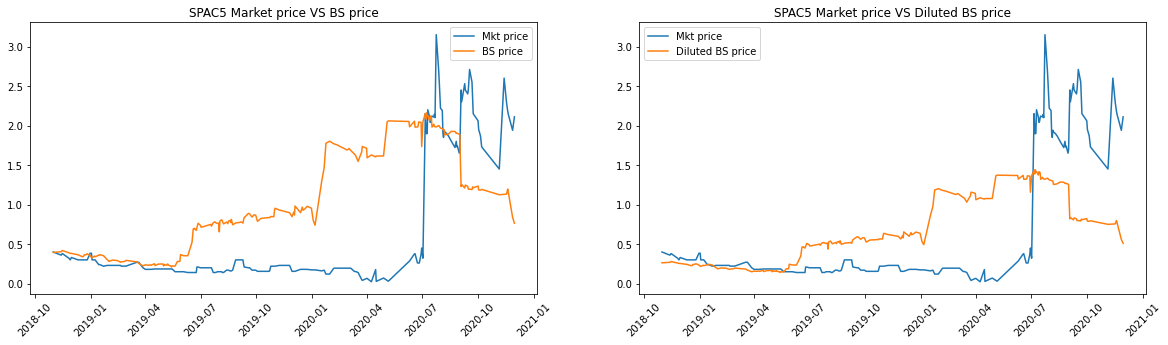

In [59]:
# spac 5
spac5 = final_prices[final_prices.spac_id == 5]
spac5 = spac5[spac5.date<'2020-12-01']

plt.figure(1,figsize=(20,5))

fig1 = plt.subplot(121)
fig1.plot(spac5.date,spac5.warrant,label='Mkt price')
# fig1.plot(spac5.date,spac5.BS_price,label='BS & constant volatility')
fig1.plot(spac5.date,spac5.BS_price_hist,label='BS price')
plt.title('SPAC5 Market price VS BS price')
plt.xticks(rotation=45)
plt.legend()

fig2 = plt.subplot(122)
fig2.plot(spac5.date,spac5.warrant,label='Mkt price')
# fig2.plot(spac5.date,spac5.Diluted_BS_price,label='Diluted BS & constant volatility')
fig2.plot(spac5.date,spac5.Diluted_BS_price_hist,label='Diluted BS price')
plt.title('SPAC5 Market price VS Diluted BS price')
plt.xticks(rotation=45)
plt.legend()

plt.show()

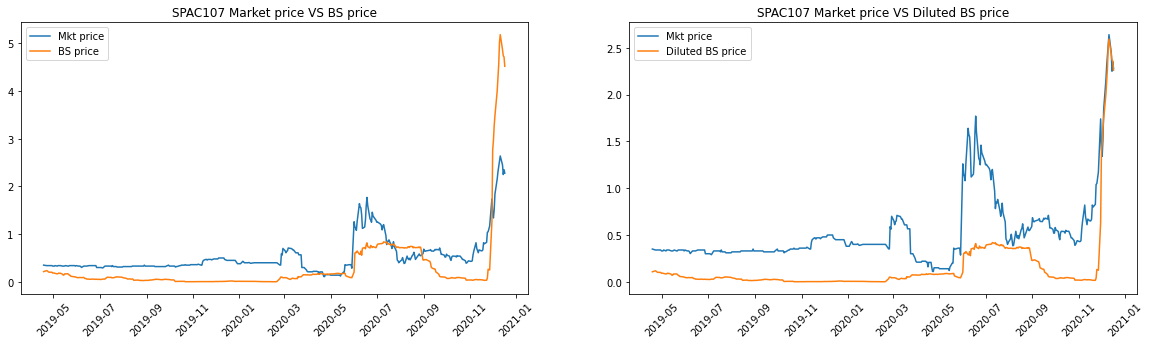

In [60]:
# spac 107
spac107 = final_prices[final_prices.spac_id == 107].drop(36009) 

plt.figure(1,figsize=(20,5))

fig1 = plt.subplot(121)
fig1.plot(spac107.date,spac107.warrant,label='Mkt price')
# fig1.plot(spac107.date,spac107.BS_price,label='BS & constant volatility')
fig1.plot(spac107.date,spac107.BS_price_hist,label='BS price')
plt.title('SPAC107 Market price VS BS price')
plt.xticks(rotation=45)
plt.legend()

fig2 = plt.subplot(122)
fig2.plot(spac107.date,spac107.warrant,label='Mkt price')
# fig2.plot(spac107.date,spac107.Diluted_BS_price,label='Diluted BS & constant volatility')
fig2.plot(spac107.date,spac107.Diluted_BS_price_hist,label='Diluted BS price')
plt.title('SPAC107 Market price VS Diluted BS price')
plt.xticks(rotation=45)
plt.legend()

plt.show()

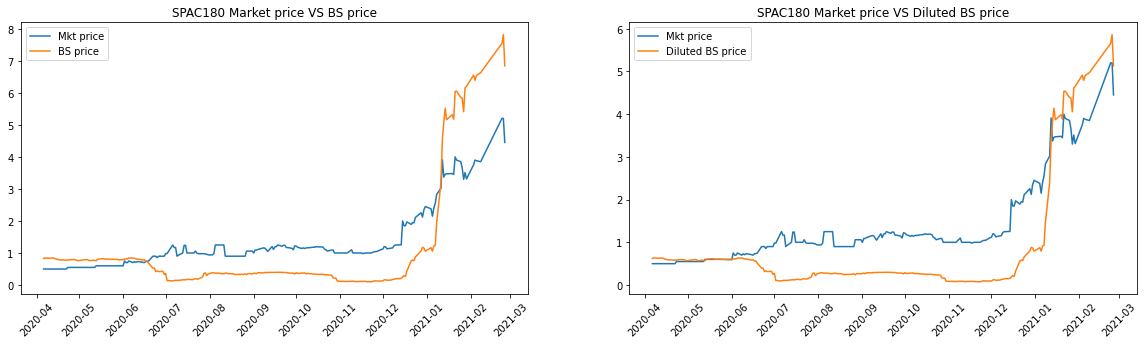

In [61]:
# spac 180
spac180 = final_prices[final_prices.spac_id == 180]

plt.figure(1,figsize=(20,5))

fig1 = plt.subplot(121)
fig1.plot(spac180.date,spac180.warrant,label='Mkt price')
# fig1.plot(spac180.date,spac180.BS_price,label='BS & constant volatility')
fig1.plot(spac180.date,spac180.BS_price_hist,label='BS price')
plt.title('SPAC180 Market price VS BS price')
plt.xticks(rotation=45)
plt.legend()

fig2 = plt.subplot(122)
fig2.plot(spac180.date,spac180.warrant,label='Mkt price')
# fig2.plot(spac180.date,spac180.Diluted_BS_price,label='Diluted BS & constant volatility')
fig2.plot(spac180.date,spac180.Diluted_BS_price_hist,label='Diluted BS price')
plt.title('SPAC180 Market price VS Diluted BS price')
plt.xticks(rotation=45)
plt.legend()

plt.show()

## MSE

In [62]:
evalue_MSE = pd.DataFrame(columns = [['BS','Dl_BS','GS']],index = GS_pricing['spac_id'].unique())

for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[GS_pricing['spac_id'] == ind]
    mse1 = ((sub['BS_price_hist'] - sub['warrant'])**2).mean()
    mse2 = ((sub['Diluted_BS_price_hist'] - sub['warrant'])**2).mean()
    mse3 = ((sub['GS_price_hist'] - sub['warrant'])**2).mean() 
    
    evalue_MSE.loc[ind,'BS'] = mse1
    evalue_MSE.loc[ind,'Dl_BS'] = mse2
    evalue_MSE.loc[ind,'GS'] = mse3

In [63]:
evalue_MSE.mean()

BS       1.708481
Dl_BS    0.997164
GS       1.583754
dtype: float64

In [64]:
itm = GS_pricing.equity >= GS_pricing.strike_price
otm = ~itm

In [65]:
len(GS_pricing)

83865

In [66]:
itm.sum()

4124

In [67]:
# itm
evalue_MSE_itm = pd.DataFrame(columns = [['BS','Dl_BS','GS']],
                              index = GS_pricing['spac_id'].unique())

for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[itm]
    sub = sub[sub['spac_id'] == ind]
    mse1 = ((sub['BS_price_hist'] - sub['warrant'])**2).mean()
    mse2 = ((sub['Diluted_BS_price_hist'] - sub['warrant'])**2).mean()
    mse3 = ((sub['GS_price_hist'] - sub['warrant'])**2).mean() 
    
    evalue_MSE_itm.loc[ind,'BS'] = mse1
    evalue_MSE_itm.loc[ind,'Dl_BS'] = mse2
    evalue_MSE_itm.loc[ind,'GS'] = mse3

In [68]:
evalue_MSE_itm.mean()

BS       10.359711
Dl_BS     3.307226
GS       10.029168
dtype: float64

In [69]:
# otm
evalue_MSE_otm = pd.DataFrame(columns = [['BS','Dl_BS','GS']],
                              index = GS_pricing['spac_id'].unique())

for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[otm]
    sub = sub[sub['spac_id'] == ind]
    mse1 = ((sub['BS_price_hist'] - sub['warrant'])**2).mean()
    mse2 = ((sub['Diluted_BS_price_hist'] - sub['warrant'])**2).mean()
    mse3 = ((sub['GS_price_hist'] - sub['warrant'])**2).mean() 
    
    evalue_MSE_otm.loc[ind,'BS'] = mse1
    evalue_MSE_otm.loc[ind,'Dl_BS'] = mse2
    evalue_MSE_otm.loc[ind,'GS'] = mse3

In [70]:
evalue_MSE_otm.mean()

BS       1.114721
Dl_BS    0.850299
GS       1.012071
dtype: float64

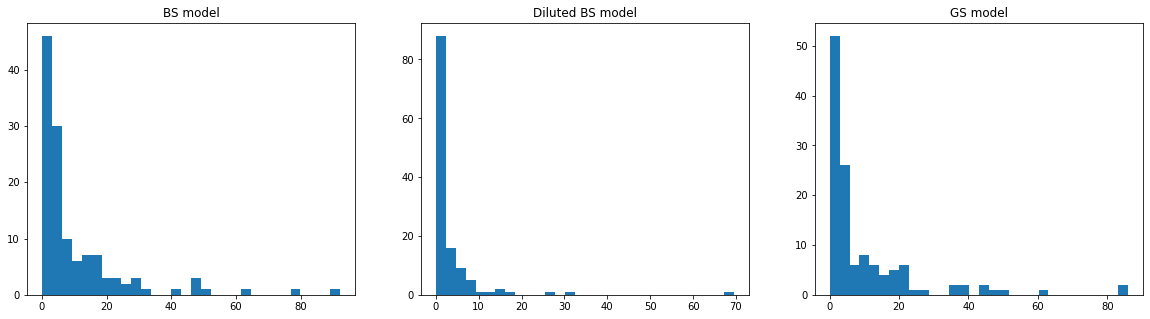

In [71]:
plt.figure(1,figsize=(20,5))

fig1 = plt.subplot(131)
fig1 = plt.hist(evalue_MSE_itm['BS'],bins=30)
plt.title('BS model')

fig2 = plt.subplot(132)
fig2 = plt.hist(evalue_MSE_itm['Dl_BS'],bins=30)
plt.title('Diluted BS model')

fig3 = plt.subplot(133)
fig3 = plt.hist(evalue_MSE_itm['GS'],bins=30)
plt.title('GS model')

plt.show()

## MAPE

In [72]:
evalue_MAPE_itm = pd.DataFrame(columns = [['BS','Dl_BS','GS']],
                               index = GS_pricing['spac_id'].unique())

In [73]:
for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[itm]
    sub = sub[sub['spac_id'] == ind]
    mape1 = (abs(sub['BS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    mape2 = (abs(sub['Diluted_BS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    mape3 = (abs(sub['GS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    
    evalue_MAPE_itm.loc[ind,'BS'] = mape1
    evalue_MAPE_itm.loc[ind,'Dl_BS'] = mape2
    evalue_MAPE_itm.loc[ind,'GS'] = mape3

In [74]:
evalue_MAPE_itm.mean()

BS       119.516534
Dl_BS     65.530826
GS       108.910869
dtype: float64

In [75]:
evalue_MAPE_otm = pd.DataFrame(columns = [['BS','Dl_BS','GS']],
                               index = GS_pricing['spac_id'].unique())

In [76]:
for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[otm]
    sub = sub[sub['spac_id'] == ind]
    mape1 = (abs(sub['BS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    mape2 = (abs(sub['Diluted_BS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    mape3 = (abs(sub['GS_price_hist'] - sub['warrant'])/sub['warrant']).mean()*100
    
    evalue_MAPE_otm.loc[ind,'BS'] = mape1
    evalue_MAPE_otm.loc[ind,'Dl_BS'] = mape2
    evalue_MAPE_otm.loc[ind,'GS'] = mape3

In [77]:
evalue_MAPE_otm.mean()

BS       158.904593
Dl_BS    128.428042
GS       145.619279
dtype: float64

## Consistent shift

In [78]:
# standard deviations of differences
diff_std = pd.DataFrame(columns = [['BS','BS_hist','Dl_BS','Dl_BS_hist','GS','GS_hist']],
                        index = GS_pricing['spac_id'].unique())

In [79]:
for ind in GS_pricing['spac_id'].unique():
    
    sub = GS_pricing[GS_pricing['spac_id'] == ind]
    std1 = (sub['BS_price'] - sub['warrant']).std()
    std2 = (sub['BS_price_hist'] - sub['warrant']).std()
    std3 = (sub['Diluted_BS_price'] - sub['warrant']).std()
    std4 = (sub['Diluted_BS_price_hist'] - sub['warrant']).std()
    std5 = (sub['GS_price'] - sub['warrant']).std()
    std6 = (sub['GS_price_hist'] - sub['warrant']).std()
    
    diff_std.loc[ind,'BS'] = std1
    diff_std.loc[ind,'BS_hist'] = std2
    diff_std.loc[ind,'Dl_BS'] = std3
    diff_std.loc[ind,'Dl_BS_hist'] = std4
    diff_std.loc[ind,'GS'] = std5
    diff_std.loc[ind,'GS_hist'] = std6

In [80]:
diff_std

,BS,BS_hist,Dl_BS,Dl_BS_hist,GS,GS_hist
1,0.080614,0.634921,0.047653,0.343573,0.065821,0.487273
3,1.221658,1.675189,0.833264,1.112057,1.094573,1.504735
5,1.529373,0.85576,1.477888,0.950534,1.526034,0.715857
6,3.62311,1.424619,2.370963,0.989031,3.625514,1.382532
7,2.891128,0.838138,1.904651,0.581372,3.786483,0.760279
...,...,...,...,...,...,...
1425,0.026014,0.026333,0.023027,0.023221,0.025187,0.025947
1429,0.035969,0.03767,0.024342,0.025346,0.03209,0.033163
1435,0.013899,0.013301,0.012271,0.011851,0.013533,0.015484
1459,0.016548,0.016598,0.014005,0.014036,0.015748,0.015698


In [81]:
diff_std.mean()

BS            0.403222
BS_hist       0.537550
Dl_BS         0.338328
Dl_BS_hist    0.368201
GS            0.416911
GS_hist       0.512148
dtype: float64

# Benchmark Strategy

We buy $100 for each warrant when it comes out, calculate the daily returns.

In [82]:
price_strag = final_prices[['spac_id','date','warrant']].merge(price[['spac_id','date','equity','rights']],
                                                               on=['spac_id','date'],how='left')
price_strag = price_strag.merge(info_spac[['spac_id','warrant_per_unit',
                                           'equity_per_unit','right_per_unit']],on='spac_id',how='left')

In [83]:
price_strag.rights[price_strag.rights == 0] = np.nan
price_strag.rights = price_strag.groupby('spac_id')['rights'].ffill().fillna(0)
price_strag.right_per_unit = price_strag.groupby('spac_id')['right_per_unit'].ffill().fillna(0)

In [84]:
# drop 1485, only one price left
price_strag[price_strag.spac_id==1485]

,spac_id,date,warrant,equity,rights,warrant_per_unit,equity_per_unit,right_per_unit
83864,1485,2022-04-29,0.0799,9.95,0.1849,1.0,1,1.0


In [85]:
price_strag = price_strag[price_strag.spac_id!=1485].reset_index(drop=True)

In [86]:
price_strag = price_strag.rename(columns={'warrant_per_unit':'wpu','equity_per_unit':'epu','right_per_unit':'rpu'})

In [87]:
price_strag['units'] = price_strag.warrant*price_strag.wpu +\
                      price_strag.equity*price_strag.epu +\
                      price_strag.rights*price_strag.rpu

In [88]:
price_strag

,spac_id,date,warrant,equity,rights,wpu,epu,rpu,units
0,1,2018-11-16,0.360,9.64,0.39,1.0,1,1.0,10.3900
1,1,2018-11-19,0.350,9.66,0.33,1.0,1,1.0,10.3400
2,1,2018-11-20,0.320,9.72,0.34,1.0,1,1.0,10.3800
3,1,2018-11-21,0.320,9.73,0.33,1.0,1,1.0,10.3800
4,1,2018-11-23,0.320,9.75,0.33,1.0,1,1.0,10.4000
...,...,...,...,...,...,...,...,...,...
83859,1435,2022-04-29,0.311,9.95,0.00,0.5,1,0.0,10.1055
83860,1459,2022-04-26,0.360,9.93,0.00,0.5,1,0.0,10.1100
83861,1459,2022-04-27,0.360,9.93,0.00,0.5,1,0.0,10.1100
83862,1459,2022-04-28,0.340,9.93,0.00,0.5,1,0.0,10.1000


In [89]:
# create benchmark portfolio
period = pd.date_range(start = price_strag.date.min(),end = price_strag.date.max(),freq = 'B')
bport = pd.DataFrame(period)
bport.columns = ['date']
bport['port_value'] = 0 # value of warrant portfolio
bport['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
bport['last_value'] = 0 # record the value of warrants at the last day
bport['last_value_unit'] = 0 # record the value of units at the last day
bport['turnover'] = 0 # trading volume in shares
bport['tcost'] = 0

In [90]:
bport

,date,port_value,unit_value,last_value,last_value_unit,turnover,tcost
0,2018-04-04,0,0,0,0,0,0
1,2018-04-05,0,0,0,0,0,0
2,2018-04-06,0,0,0,0,0,0
3,2018-04-09,0,0,0,0,0,0
4,2018-04-10,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1058,2022-04-25,0,0,0,0,0,0
1059,2022-04-26,0,0,0,0,0,0
1060,2022-04-27,0,0,0,0,0,0
1061,2022-04-28,0,0,0,0,0,0


In [91]:
cap = 100 # $ initial value for each warrant
tc = 0.05 # transaction cost in percentage
all_id = price_strag.spac_id.unique()

In [92]:
for i in all_id:
    
    sub_price = price_strag[price_strag.spac_id==i]
    
    # buy $cap warrant at its first close price 
    unit = (cap/sub_price.warrant.values[0]).round()
    
    # merge prices & ffill the missing prices
    bport = bport.merge(sub_price[['date','warrant','units','wpu']], on='date', how='left')
    inrange_date = (bport.date>=sub_price.date.iloc[0])&(bport.date<=sub_price.date.iloc[-1])
    bport[inrange_date] = bport[inrange_date].ffill()
    
    # the shares of warrant
    bport['share'] = np.nan
    bport.share[inrange_date] = unit
    bport.share[inrange_date] = bport[inrange_date].share.shift(1)
    bport = bport.fillna(0)
    
    # update warrant portfolio value
    bport.port_value = bport.port_value + bport.warrant*bport.share
    
    # update unit portfolio value
    bport.unit_value = bport.unit_value + ((bport.share/bport.wpu) * bport.units).fillna(0)
    
    # update the last day value
    last_day = bport.index[inrange_date][-1]
    bport.loc[last_day,'last_value'] = (bport.loc[last_day,'last_value'] +
                                        bport.loc[last_day,'warrant']*bport.loc[last_day,'share'])
    bport.loc[last_day,'last_value_unit'] = (bport.loc[last_day,'last_value_unit'] +
                                             bport.loc[last_day,'units']*bport.loc[last_day,'share']/bport.loc[last_day,'wpu'])
    
    # update transaction cost
    trad_vol = abs(bport.share.diff().fillna(0))
    bport.tcost = bport.tcost + trad_vol*bport.warrant*tc
    
    # update trading volume
    bport.turnover = bport.turnover + trad_vol
    
    bport = bport.drop(['warrant','share','units','wpu'],axis=1)

In [93]:
bport

,date,port_value,unit_value,last_value,last_value_unit,turnover,tcost
0,2018-04-04,0.0000,0.000000,0.0000,0.000000,0.0,0.000000
1,2018-04-05,2354.9851,67686.467100,0.0000,0.000000,4154.0,117.749255
2,2018-04-06,2400.9558,68848.247800,0.0000,0.000000,133.0,4.969545
3,2018-04-09,2514.2855,69875.612500,0.0000,0.000000,112.0,4.872000
4,2018-04-10,2569.8312,70066.073200,0.0000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
1058,2022-04-25,10411.9225,806624.728733,0.0000,0.000000,370.0,5.365000
1059,2022-04-26,10160.9051,806397.804733,0.0000,0.000000,0.0,0.000000
1060,2022-04-27,10655.1214,853840.222533,0.0000,0.000000,2336.0,31.828665
1061,2022-04-28,10351.2831,852944.575100,114.6858,5954.389900,0.0,0.000000


In [94]:
bret = bport.copy()
bret[['last_value','last_value_unit']] = bret[['last_value','last_value_unit']].shift(1).fillna(0)

In [95]:
bret['daily_ret'] = (bret['port_value'].diff()+bret['last_value'])/(bret['unit_value'].shift(1)-bret['last_value_unit'])

In [96]:
# embed trading cost
bret['pct_tcost'] = bret['tcost']/bret['unit_value']
bret['daily_ret'] = bret['daily_ret'] - bret['pct_tcost']

In [97]:
bret = bret.drop([0,1]).reset_index(drop=True)
bret['cum_ret'] = (bret.daily_ret + 1).cumprod() - 1
bret

,date,port_value,unit_value,last_value,last_value_unit,turnover,tcost,daily_ret,pct_tcost,cum_ret
0,2018-04-06,2400.9558,68848.247800,0.0000,0.0000,133.0,4.969545,0.000607,0.000072,0.000607
1,2018-04-09,2514.2855,69875.612500,0.0000,0.0000,112.0,4.872000,0.001576,0.000070,0.002184
2,2018-04-10,2569.8312,70066.073200,0.0000,0.0000,0.0,0.000000,0.000795,0.000000,0.002981
3,2018-04-11,2559.0852,69715.866800,0.0000,0.0000,0.0,0.000000,-0.000153,0.000000,0.002827
4,2018-04-12,2563.5874,69478.809400,0.0000,0.0000,0.0,0.000000,0.000065,0.000000,0.002892
...,...,...,...,...,...,...,...,...,...,...
1056,2022-04-25,10411.9225,806624.728733,0.0000,0.0000,370.0,5.365000,-0.000084,0.000007,0.294125
1057,2022-04-26,10160.9051,806397.804733,0.0000,0.0000,0.0,0.000000,-0.000311,0.000000,0.293723
1058,2022-04-27,10655.1214,853840.222533,0.0000,0.0000,2336.0,31.828665,0.000576,0.000037,0.294467
1059,2022-04-28,10351.2831,852944.575100,0.0000,0.0000,0.0,0.000000,-0.000356,0.000000,0.294007


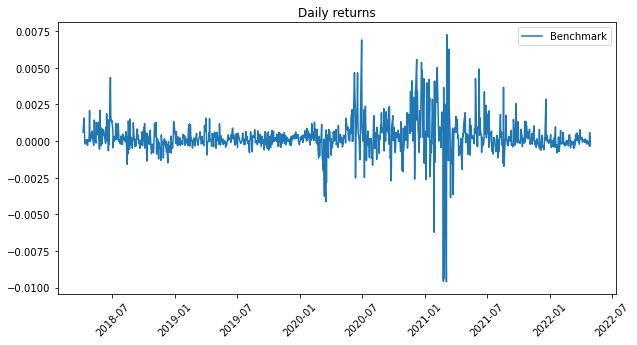

In [98]:
# daily returns
plt.figure(figsize=(10,5))
plt.plot(bret['date'],bret['daily_ret'],label='Benchmark')
plt.xticks(rotation=45)
plt.title('Daily returns')
plt.legend()
plt.show()

In [99]:
# max drawdown
bret['daily_ret'].min()

-0.009604323127816618

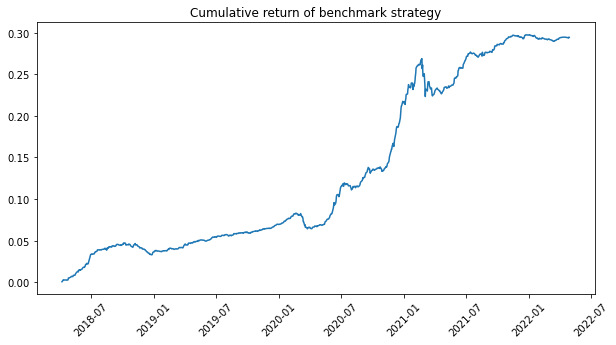

In [100]:
plt.figure(figsize=(10,5))
plt.plot(bret['date'],bret['cum_ret'])
plt.xticks(rotation=45)
plt.title('Cumulative return of benchmark strategy')
plt.show()

# Rebalance the portfolio using Diluted-BS model

In [101]:
price_reb = price_strag.copy()
price_reb = price_reb.merge(final_prices[['spac_id','date','Diluted_BS_price_hist']],
                            on=['spac_id','date'],how='left')
price_reb = price_reb.rename(columns={'Diluted_BS_price_hist':'mdl_p','warrant':'mkt_p'}).ffill()

In [102]:
# the difference between two prices
price_reb['p_diff'] = price_reb.mdl_p - price_reb.mkt_p
pct_diff = price_reb.p_diff / price_reb.mkt_p
pct_diff = np.where(pct_diff>1,1,pct_diff) # upper limit for pct change

In [103]:
price_reb['pct_diff'] = pct_diff
price_reb['pct_diff'] = price_reb['pct_diff'].fillna(0)
price_reb

,spac_id,date,mkt_p,equity,rights,wpu,epu,rpu,units,mdl_p,p_diff,pct_diff
0,1,2018-11-16,0.360,9.64,0.39,1.0,1,1.0,10.3900,0.059826,-0.300174,-0.833816
1,1,2018-11-19,0.350,9.66,0.33,1.0,1,1.0,10.3400,0.061794,-0.288206,-0.823446
2,1,2018-11-20,0.320,9.72,0.34,1.0,1,1.0,10.3800,0.072768,-0.247232,-0.772601
3,1,2018-11-21,0.320,9.73,0.33,1.0,1,1.0,10.3800,0.083718,-0.236282,-0.738383
4,1,2018-11-23,0.320,9.75,0.33,1.0,1,1.0,10.4000,0.085615,-0.234385,-0.732454
...,...,...,...,...,...,...,...,...,...,...,...,...
83859,1435,2022-04-29,0.311,9.95,0.00,0.5,1,0.0,10.1055,0.136353,-0.174647,-0.561566
83860,1459,2022-04-26,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.114322,-0.245678,-0.682439
83861,1459,2022-04-27,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.120065,-0.239935,-0.666487
83862,1459,2022-04-28,0.340,9.93,0.00,0.5,1,0.0,10.1000,0.123495,-0.216505,-0.636778


## Strategy 1 

Reduce/Increase the holding shares of warrant by the percentage difference between model price and market price.\
Daily trading volume for each warrant should be less than ()% of the present shares.\
Total holding for each warrant should be lower than ()*initial shares.\
Rebalance weekly.

In [104]:
# create portfolio
port1 = pd.DataFrame(period)
port1.columns = ['date']
port1['port_value'] = 0
port1['last_value'] = 0 # record the value of warrants at the last day
port1['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port1['last_value_unit'] = 0 # record the value of units at the last day
port1['tcost'] = 0 # transaction cost (assuming 10% per share)
port1['turnover'] = 0 # trading volume in shares
port1['reb_day'] = np.nan

In [105]:
reb_freq = pd.date_range(start = '2018-04-04',end = '2022-05-01',freq = 'W') - dt.timedelta(days = 2)
reb_freq

DatetimeIndex(['2018-04-06', '2018-04-13', '2018-04-20', '2018-04-27',
               '2018-05-04', '2018-05-11', '2018-05-18', '2018-05-25',
               '2018-06-01', '2018-06-08',
               ...
               '2022-02-25', '2022-03-04', '2022-03-11', '2022-03-18',
               '2022-03-25', '2022-04-01', '2022-04-08', '2022-04-15',
               '2022-04-22', '2022-04-29'],
              dtype='datetime64[ns]', length=213, freq=None)

In [106]:
port1.reb_day[port1.date.isin(reb_freq)] = 1 # 1 means we need to rebalance the portfolio at that day
port1

,date,port_value,last_value,unit_value,last_value_unit,tcost,turnover,reb_day
0,2018-04-04,0,0,0,0,0,0,NaN
1,2018-04-05,0,0,0,0,0,0,NaN
2,2018-04-06,0,0,0,0,0,0,1.0
3,2018-04-09,0,0,0,0,0,0,NaN
4,2018-04-10,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...
1058,2022-04-25,0,0,0,0,0,0,NaN
1059,2022-04-26,0,0,0,0,0,0,NaN
1060,2022-04-27,0,0,0,0,0,0,NaN
1061,2022-04-28,0,0,0,0,0,0,NaN


In [107]:
def strategy1(u,d,m,h,tc,cap,port,price_reb):
    
    for i in all_id:

        sub_price = price_reb[price_reb.spac_id==i]

        # buy $cap warrant at its first close price 
        unit = (cap/sub_price.mkt_p.values[0]).round()

        # merge market prices & percentage difference
        port = port.merge(sub_price[['date','mkt_p','pct_diff','units','wpu']], on='date', how='left')
        inrange_date = (port.date>=sub_price.date.iloc[0])&(port.date<=sub_price.date.iloc[-1])
        port.pct_diff[inrange_date] = port[inrange_date].pct_diff.fillna(0)
        port[inrange_date] = port[inrange_date].ffill()

        # the original shares of warrant
        port['share'] = np.nan
        port.share[inrange_date] = unit
        port.share[inrange_date] = port[inrange_date].share.shift(1)

        # adjust shares weekly
        port['adj_share'] = np.nan
        adjust = 1+port.pct_diff[inrange_date]*h
        adjust = np.where(adjust>u,u,adjust) # limit for daily shares increase
        adjust = np.where(adjust<d,d,adjust) # limit for daily shares decrease
        new_share = (port.share[inrange_date] * adjust.cumprod() * port.reb_day[inrange_date]).round().shift(1)
        new_share.iloc[1] = unit 
        new_share = new_share.ffill()
        new_share = np.where(new_share>m*unit,m*unit,new_share) # upper limit for total holding shares
        new_share = np.where(new_share<1,0,new_share)
        port['adj_share'][inrange_date] = new_share

        # update warrant portfolio value
        port[['mkt_p','adj_share']] = port[['mkt_p','adj_share']].fillna(0)
        port.port_value = (port.port_value + port.mkt_p*port.adj_share)
        
        # update unit portfolio value
        port.unit_value = port.unit_value + ((port.adj_share/port.wpu)*port.units).fillna(0)
        
        # update the last day value
        last_day = port.index[inrange_date][-1]
        port.loc[last_day,'last_value'] = port.loc[last_day,'last_value'] +\
                                          port.loc[last_day,'mkt_p']*port.loc[last_day,'adj_share']
        port.loc[last_day,'last_value_unit'] = (port.loc[last_day,'last_value_unit'] +
                                                port.loc[last_day,'units']*
                                                port.loc[last_day,'adj_share']/port.loc[last_day,'wpu'])
        
        # update transaction cost
        trad_vol = abs(port.adj_share.diff().fillna(0))
        port.tcost = port.tcost + trad_vol*port.mkt_p*tc
        
        # update trading volume
        port.turnover = port.turnover + trad_vol
        
        port = port.drop(['mkt_p','pct_diff','share','adj_share','units','wpu'],axis=1)

    port = port.fillna(0)
    
    return port

In [108]:
u = 1.5 # limit for daily shares increase
d = 0.5 # limit for daily shares decrease
m = 10 # upper limit for total holding shares
h = 0.5 # part of the difference used in strategy
tc = 0.05 # transaction cost
cap = 100 # initial value for each warrant
p1 = strategy1(u,d,m,h,tc,cap,port1,price_reb)

In [109]:
p1.turnover.mean()

431.63217309501414

In [110]:
p1

,date,port_value,last_value,unit_value,last_value_unit,tcost,turnover,reb_day
0,2018-04-04,0.0000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,2018-04-05,2354.9851,0.0000,67686.467100,0.000000,117.749255,4154.0,0.0
2,2018-04-06,2400.9558,0.0000,68848.247800,0.000000,4.969545,133.0,1.0
3,2018-04-09,1778.9515,0.0000,39490.830500,0.000000,90.238620,3209.0,1.0
4,2018-04-10,2037.9508,0.0000,40895.476800,0.000000,25.123270,892.0,1.0
...,...,...,...,...,...,...,...,...
1058,2022-04-25,3736.2791,0.0000,369916.849100,0.000000,20.142135,2145.0,1.0
1059,2022-04-26,3561.0078,0.0000,364345.591133,0.000000,4.009755,319.0,1.0
1060,2022-04-27,4044.9378,0.0000,408262.337800,0.000000,33.914125,2509.0,1.0
1061,2022-04-28,3965.7050,0.0000,389628.157600,0.000000,12.593530,936.0,1.0


In [111]:
p1ret = p1.copy()
p1ret[['last_value','last_value_unit']] = p1ret[['last_value','last_value_unit']].shift(1).fillna(0)
p1ret['daily_ret'] = (p1ret['port_value'].diff()+p1ret['last_value'])/(p1ret['unit_value'].shift(1)-p1ret['last_value_unit'])
p1ret = p1ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p1ret['pct_tcost'] = p1ret['tcost']/p1ret['unit_value']
p1ret['daily_ret'] = p1ret['daily_ret'] - p1ret['pct_tcost']

p1ret

,date,port_value,last_value,unit_value,last_value_unit,tcost,turnover,reb_day,daily_ret,pct_tcost
0,2018-04-06,2400.9558,0.0,68848.247800,0.0,4.969545,133.0,1.0,0.000607,0.000072
1,2018-04-09,1778.9515,0.0,39490.830500,0.0,90.238620,3209.0,1.0,-0.011319,0.002285
2,2018-04-10,2037.9508,0.0,40895.476800,0.0,25.123270,892.0,1.0,0.005944,0.000614
3,2018-04-11,2485.7939,0.0,45253.368700,0.0,29.999155,1073.0,1.0,0.010288,0.000663
4,2018-04-12,2999.2759,0.0,51341.979900,0.0,33.396230,1204.0,1.0,0.010696,0.000650
...,...,...,...,...,...,...,...,...,...,...
1056,2022-04-25,3736.2791,0.0,369916.849100,0.0,20.142135,2145.0,1.0,0.000809,0.000054
1057,2022-04-26,3561.0078,0.0,364345.591133,0.0,4.009755,319.0,1.0,-0.000485,0.000011
1058,2022-04-27,4044.9378,0.0,408262.337800,0.0,33.914125,2509.0,1.0,0.001245,0.000083
1059,2022-04-28,3965.7050,0.0,389628.157600,0.0,12.593530,936.0,1.0,-0.000226,0.000032


In [112]:
compar = rf[['date','rf_rate']].copy()
compar = compar.merge(bret[['date','daily_ret']],on=['date'],how='inner')
compar = compar.merge(p1ret[['date','daily_ret']],on=['date'],how='inner')
compar = compar.rename(columns={'daily_ret_x':'bp_dret','daily_ret_y':'p1_dret'})

In [113]:
compar['bp_cumret'] = (compar.bp_dret + 1).cumprod() - 1
compar['p1_cumret'] = (compar.p1_dret + 1).cumprod() - 1

In [114]:
compar

,date,rf_rate,bp_dret,p1_dret,bp_cumret,p1_cumret
0,2018-04-06,0.0277,0.000607,0.000607,0.000607,0.000607
1,2018-04-09,0.0278,0.001576,-0.011319,0.002184,-0.010719
2,2018-04-10,0.0280,0.000795,0.005944,0.002981,-0.004839
3,2018-04-11,0.0279,-0.000153,0.010288,0.002827,0.005399
4,2018-04-12,0.0283,0.000065,0.010696,0.002892,0.016153
...,...,...,...,...,...,...
1056,2022-04-25,0.0281,-0.000084,0.000809,0.294125,0.261811
1057,2022-04-26,0.0277,-0.000311,-0.000485,0.293723,0.261199
1058,2022-04-27,0.0282,0.000576,0.001245,0.294467,0.262770
1059,2022-04-28,0.0285,-0.000356,-0.000226,0.294007,0.262484


In [115]:
yr = (compar.date.max() - compar.date.min()).days/365
yr

4.065753424657534

In [116]:
# annualized return
bp_anret = pow(1 + compar['bp_cumret'].iloc[-1],1/yr) - 1
p1_anret = pow(1 + compar['p1_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p1_anret)

0.06551816836285207 0.058938403357429836


In [117]:
# annualized volatility
bp_anvol = compar['bp_dret'].std()*np.sqrt(250)
p1_anvol = compar['p1_dret'].std()*np.sqrt(250)
print(bp_anvol,p1_anvol)

0.01950668582119034 0.03830443354166091


In [118]:
last_rf = compar.rf_rate.iloc[-1]

In [119]:
# sharpe ratio
bp_SR = (bp_anret - last_rf) / bp_anvol
p1_SR = (p1_anret - last_rf) / p1_anvol
print(bp_SR,p1_SR)

1.8772111622915115 0.7842017380249019


In [120]:
compar['p1_dret'].min()

-0.011589705696559162

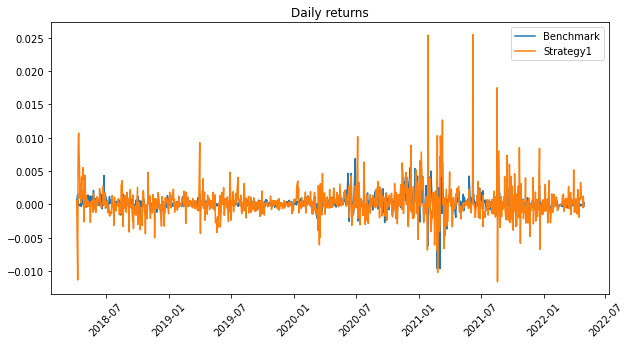

In [121]:
# daily returns
plt.figure(figsize=(10,5))
plt.plot(compar['date'],compar['bp_dret'],label='Benchmark')
plt.plot(compar['date'],compar['p1_dret'],label='Strategy1')
plt.xticks(rotation=45)
plt.title('Daily returns')
plt.legend()
plt.show()

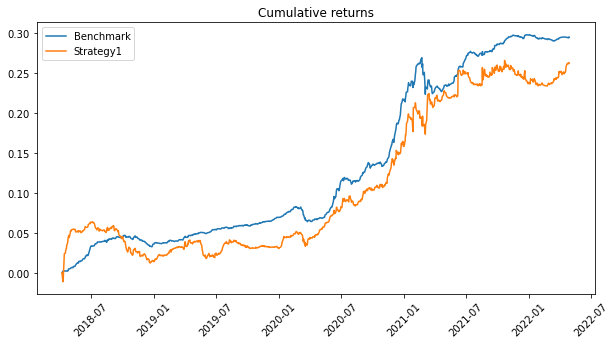

In [122]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar['date'],compar['bp_cumret'],label='Benchmark')
plt.plot(compar['date'],compar['p1_cumret'],label='Strategy1')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

## Strategy 2

Buy-and-hold when the market cool down, manage the portfolio activly when the market is hot.

### 1) find market trend signal 

#### Market Value 

In [123]:
spac_mkt = price[['spac_id','date','unit','equity','warrant','rights']].\
           merge(info_spac[['spac_id','warrant_per_unit','equity_per_unit','right_per_unit']],on='spac_id',how='left').\
           merge(event[['spac_id','effective_date','shares_outstanding']],
                 left_on=['spac_id','date'],right_on=['spac_id','effective_date'],how='left')

In [124]:
spac_mkt = spac_mkt.drop(['effective_date'],axis=1)
spac_mkt['shares_outstanding'] = spac_mkt['shares_outstanding'].ffill().bfill()
spac_mkt = spac_mkt.fillna(0)

In [125]:
def mv(u,e,w,r,wpu,epu,rpu,shares):
    if u !=0:
        mkt_val = u*shares
    else:
        mkt_val = shares*(e*epu+w*wpu+r*rpu)
    return mkt_val

In [126]:
spac_mkt['MktValue'] = spac_mkt.apply(lambda x:mv(x['unit'],x['equity'],x['warrant'],x['rights'],
                                                  x['warrant_per_unit'],x['equity_per_unit'],x['right_per_unit'],
                                                  x['shares_outstanding']),axis=1)

In [127]:
spac_mkt

,spac_id,date,unit,equity,warrant,rights,warrant_per_unit,equity_per_unit,right_per_unit,shares_outstanding,MktValue
0,1,2018-08-15,10.25,9.53,0.3600,0.4000,1.0,1.0,1.0,14950000.0,153237500.0
1,1,2018-08-16,10.22,9.52,0.3600,0.4000,1.0,1.0,1.0,14950000.0,152789000.0
2,1,2018-08-17,0.00,9.53,0.3600,0.4220,1.0,1.0,1.0,14950000.0,154164400.0
3,1,2018-08-20,0.00,9.52,0.3401,0.4300,1.0,1.0,1.0,14950000.0,153836995.0
4,1,2018-08-21,0.00,9.54,0.3400,0.4100,1.0,1.0,1.0,14950000.0,153835500.0
...,...,...,...,...,...,...,...,...,...,...,...
299247,1503,2022-04-25,0.00,9.88,0.1806,0.1474,0.5,1.0,1.0,17250000.0,174530325.0
299248,1503,2022-04-26,0.00,9.88,0.1650,0.1500,0.5,1.0,1.0,17250000.0,174440625.0
299249,1503,2022-04-27,0.00,9.91,0.2000,0.1475,0.5,1.0,1.0,17250000.0,175216875.0
299250,1503,2022-04-28,0.00,9.91,0.1826,0.1475,0.5,1.0,1.0,17250000.0,175066800.0


In [128]:
spac_mv = spac_mkt.groupby('date')['MktValue'].sum().reset_index()

In [129]:
spac_mv

,date,MktValue
0,2003-09-09,6.379740e+07
1,2003-09-10,6.485540e+07
2,2003-09-11,5.247680e+07
3,2003-09-12,6.390320e+07
4,2003-09-16,6.474960e+07
...,...,...
4673,2022-04-25,1.188587e+11
4674,2022-04-26,1.187276e+11
4675,2022-04-27,1.184685e+11
4676,2022-04-28,1.190474e+11


In [130]:
monthend = pd.date_range(start = '2016-01-01',end = '2022-04-29',freq = 'BM')
spac_mv_m = spac_mv[spac_mv.date.isin(monthend)].reset_index(drop=True)

In [131]:
spac_mv_m['MonthGrowth'] = spac_mv_m.MktValue.pct_change()

In [132]:
spac_mv_m['MG_hist_mean'] = spac_mv_m.rolling(12)['MonthGrowth'].mean().shift(1)

In [133]:
spac_mv_m

,date,MktValue,MonthGrowth,MG_hist_mean
0,2016-01-29,4.750623e+09,NaN,NaN
1,2016-02-29,4.427588e+09,-0.067998,NaN
2,2016-03-31,3.170458e+09,-0.283931,NaN
3,2016-04-29,2.429324e+09,-0.233762,NaN
4,2016-05-31,2.860804e+09,0.177613,NaN
...,...,...,...,...
70,2021-12-31,1.221929e+11,-0.035113,0.100089
71,2022-01-31,1.159021e+11,-0.051482,0.093846
72,2022-02-28,1.116378e+11,-0.036792,0.068032
73,2022-03-31,1.182372e+11,0.059115,0.067039


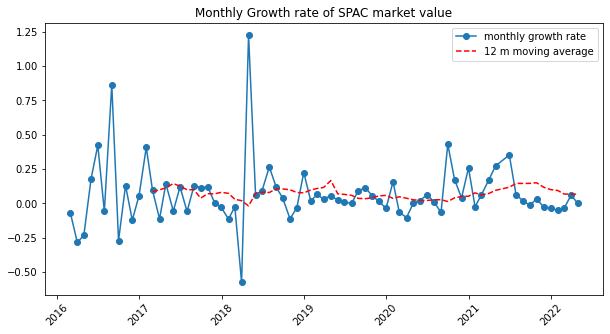

In [134]:
plt.figure(figsize=(10,5))
plt.plot(spac_mv_m['date'],spac_mv_m['MonthGrowth'],marker='o',label='monthly growth rate')
plt.plot(spac_mv_m['date'],spac_mv_m['MG_hist_mean'],color='r',linestyle='--',label='12 m moving average')
plt.xticks(rotation=45)
plt.title('Monthly Growth rate of SPAC market value')
plt.legend()
plt.show()

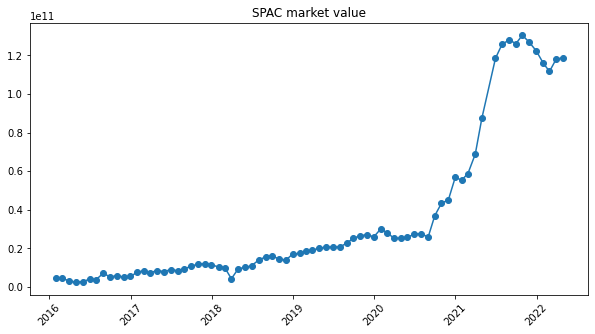

In [135]:
plt.figure(figsize=(10,5))
plt.plot(spac_mv_m['date'],spac_mv_m['MktValue'],marker='o')
plt.xticks(rotation=45)
plt.title('SPAC market value')
plt.show()

In [136]:
spac_mv_m['date_1yr'] = spac_mv_m['date'] + dt.timedelta(days=365)
spac_mv_y = spac_mv_m[['date','MktValue']].merge(spac_mv_m[['date_1yr','MktValue']],
                                                 left_on='date',right_on='date_1yr',how='left')

In [137]:
spac_mv_y['MktValue_y'] = spac_mv_y['MktValue_y'].ffill()
spac_mv_y = spac_mv_y.drop(['date_1yr'],axis=1).dropna().reset_index(drop=True)

In [138]:
spac_mv_y['YearGrowth'] = (spac_mv_y.MktValue_x - spac_mv_y.MktValue_y)/spac_mv_y.MktValue_y

In [139]:
spac_mv_y['YG_hist_mean'] = spac_mv_y.rolling(12)['YearGrowth'].mean()

In [140]:
spac_mv_y

,date,MktValue_x,MktValue_y,YearGrowth,YG_hist_mean
0,2017-02-28,8.401513e+09,4.427588e+09,0.897537,NaN
1,2017-03-31,7.454083e+09,3.170458e+09,1.351106,NaN
2,2017-04-28,8.517188e+09,3.170458e+09,1.686422,NaN
3,2017-05-31,8.041187e+09,2.860804e+09,1.810814,NaN
4,2017-06-30,9.006742e+09,4.071239e+09,1.212285,NaN
...,...,...,...,...,...
57,2021-12-31,1.221929e+11,5.676222e+10,1.152714,2.198197
58,2022-01-31,1.159021e+11,5.676222e+10,1.041888,2.190774
59,2022-02-28,1.116378e+11,5.676222e+10,0.966762,2.181507
60,2022-03-31,1.182372e+11,6.878785e+10,0.718868,2.140924


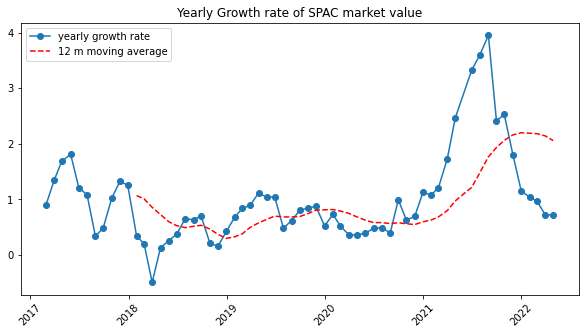

In [141]:
plt.figure(figsize=(10,5))
plt.plot(spac_mv_y['date'],spac_mv_y['YearGrowth'],marker='o',label='yearly growth rate')
plt.plot(spac_mv_y['date'],spac_mv_y['YG_hist_mean'],color='r',linestyle='--',label='12 m moving average')
plt.xticks(rotation=45)
plt.title('Yearly Growth rate of SPAC market value')
plt.legend()
plt.show()

#### Successful SPAC

In [142]:
suc_spac = event[event.code == 'COMPLETE'].reset_index(drop=True)
suc_spac['year'] = suc_spac.effective_date.dt.year
suc_spac['month'] = suc_spac.effective_date.dt.month
suc_spac

,spac_id,code,reported_date,effective_date,trust_date,trust_per_share,shares_outstanding,state_type_id,year,month
0,2,COMPLETE,2018-08-23,2018-08-23,NaT,NaN,NaN,5.0,2018,8
1,3,COMPLETE,2018-12-10,2018-12-10,NaT,NaN,NaN,5.0,2018,12
2,5,COMPLETE,2021-05-25,2021-05-25,NaT,NaN,NaN,5.0,2021,5
3,6,COMPLETE,2019-05-14,2019-05-14,NaT,NaN,NaN,5.0,2019,5
4,7,COMPLETE,2019-08-12,2019-08-12,NaT,NaN,NaN,5.0,2019,8
...,...,...,...,...,...,...,...,...,...,...
512,1000,COMPLETE,2021-12-17,2021-12-17,NaT,NaN,NaN,5.0,2021,12
513,1053,COMPLETE,2022-04-23,2022-04-25,NaT,NaN,NaN,5.0,2022,4
514,1054,COMPLETE,2021-12-28,2021-12-28,NaT,NaN,NaN,5.0,2021,12
515,1074,COMPLETE,2021-12-01,2021-12-07,NaT,NaN,NaN,5.0,2021,12


In [143]:
# amount
suc_spac_m = suc_spac.groupby(['year','month'])['spac_id'].nunique().reset_index()
suc_spac_m = suc_spac_m.rename(columns={'spac_id':'number'})
suc_spac_m['day'] = 1

In [144]:
from pandas.tseries.offsets import MonthEnd
suc_spac_date = pd.to_datetime(suc_spac_m[['year','month','day']],format='%Y-%m') + MonthEnd(0)

In [145]:
suc_spac_m['date'] = suc_spac_date
suc_spac_m = suc_spac_m[suc_spac_m.year>=2017].reset_index(drop=True).drop(['year','month','day'],axis=1)

In [146]:
suc_spac_m['suc_hist_mean'] = suc_spac_m.rolling(12).number.mean().shift(1)

In [147]:
suc_spac_m

,number,date,suc_hist_mean
0,2,2017-01-31,NaN
1,2,2017-02-28,NaN
2,2,2017-03-31,NaN
3,1,2017-04-30,NaN
4,2,2017-06-30,NaN
5,4,2017-07-31,NaN
6,1,2017-08-31,NaN
7,1,2017-10-31,NaN
8,2,2017-11-30,NaN
9,1,2017-12-31,NaN


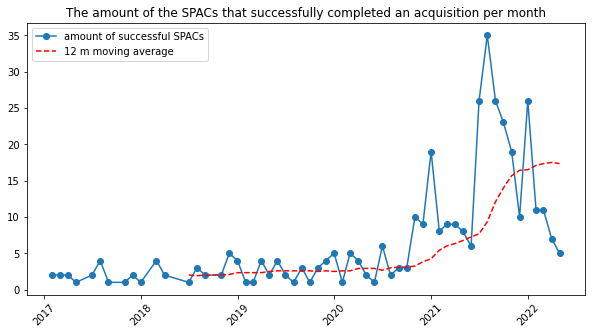

In [148]:
plt.figure(figsize=(10,5))
plt.plot(suc_spac_m['date'],suc_spac_m['number'],marker='o',label='amount of successful SPACs')
plt.plot(suc_spac_m['date'],suc_spac_m['suc_hist_mean'],color='r',linestyle='--',label='12 m moving average')
plt.xticks(rotation=45)
plt.legend()
plt.title('The amount of the SPACs that successfully completed an acquisition per month')
plt.show()

In [149]:
suc_spac_y = suc_spac.groupby('year')['spac_id'].count().reset_index()
suc_spac_y = suc_spac_y.rename(columns={'spac_id':'number'})[suc_spac_y.year>=2017].reset_index(drop=True)
suc_spac_y

,year,number
0,2017,18
1,2018,23
2,2019,31
3,2020,65
4,2021,205
5,2022,34


In [150]:
# (successful SPAC / all SPAC) every month
ttl_spac = price.groupby('date')['spac_id'].count().reset_index()
ttl_spac = ttl_spac[ttl_spac.date.isin(monthend)].reset_index(drop=True).rename(columns={'spac_id':'ttl_amount'})
ttl_spac['date'] = ttl_spac['date'] + MonthEnd(0)
ttl_spac

,date,ttl_amount
0,2016-01-31,41
1,2016-02-29,36
2,2016-03-31,33
3,2016-04-30,29
4,2016-05-31,31
...,...,...
70,2021-12-31,455
71,2022-01-31,457
72,2022-02-28,436
73,2022-03-31,449


In [151]:
suc_spac_m = suc_spac_m.merge(ttl_spac,on='date',how='left')
suc_spac_m['ttl_amount'] = suc_spac_m['ttl_amount'].ffill().shift(1)
suc_spac_m['ratio'] = suc_spac_m['number'] / suc_spac_m['ttl_amount']

In [152]:
suc_spac_m['ratio_ma'] = suc_spac_m.rolling(12).ratio.mean().shift(1)
suc_spac_m

,number,date,suc_hist_mean,ttl_amount,ratio,ratio_ma
0,2,2017-01-31,NaN,NaN,NaN,NaN
1,2,2017-02-28,NaN,37.0,0.054054,NaN
2,2,2017-03-31,NaN,41.0,0.048780,NaN
3,1,2017-04-30,NaN,39.0,0.025641,NaN
4,2,2017-06-30,NaN,39.0,0.051282,NaN
5,4,2017-07-31,NaN,46.0,0.086957,NaN
6,1,2017-08-31,NaN,45.0,0.022222,NaN
7,1,2017-10-31,NaN,47.0,0.021277,NaN
8,2,2017-11-30,NaN,56.0,0.035714,NaN
9,1,2017-12-31,NaN,57.0,0.017544,NaN


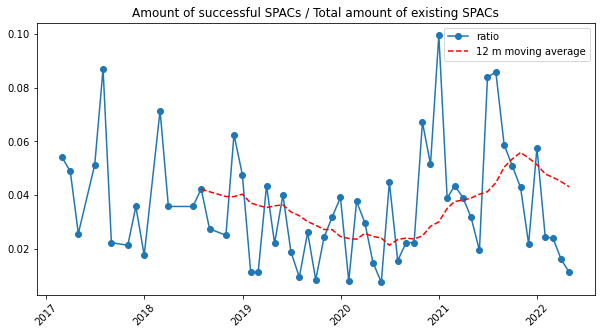

In [153]:
plt.figure(figsize=(10,5))
plt.plot(suc_spac_m['date'],suc_spac_m['ratio'],marker='o',label='ratio')
plt.plot(suc_spac_m['date'],suc_spac_m['ratio_ma'],color='r',linestyle='--',label='12 m moving average')
plt.legend()
plt.xticks(rotation=45)
plt.title('Amount of successful SPACs / Total amount of existing SPACs')
plt.show()

### 2) add the market trend signal and use moving average pct_diff

In [154]:
# ma of pc_diff
price_reb['pct_diff_ma'] = price_reb.groupby(['spac_id'])['pct_diff'].rolling(21).mean().reset_index(drop=True)
price_reb = price_reb.fillna(0)

In [155]:
price_reb

,spac_id,date,mkt_p,equity,rights,wpu,epu,rpu,units,mdl_p,p_diff,pct_diff,pct_diff_ma
0,1,2018-11-16,0.360,9.64,0.39,1.0,1,1.0,10.3900,0.059826,-0.300174,-0.833816,0.0
1,1,2018-11-19,0.350,9.66,0.33,1.0,1,1.0,10.3400,0.061794,-0.288206,-0.823446,0.0
2,1,2018-11-20,0.320,9.72,0.34,1.0,1,1.0,10.3800,0.072768,-0.247232,-0.772601,0.0
3,1,2018-11-21,0.320,9.73,0.33,1.0,1,1.0,10.3800,0.083718,-0.236282,-0.738383,0.0
4,1,2018-11-23,0.320,9.75,0.33,1.0,1,1.0,10.4000,0.085615,-0.234385,-0.732454,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83859,1435,2022-04-29,0.311,9.95,0.00,0.5,1,0.0,10.1055,0.136353,-0.174647,-0.561566,0.0
83860,1459,2022-04-26,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.114322,-0.245678,-0.682439,0.0
83861,1459,2022-04-27,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.120065,-0.239935,-0.666487,0.0
83862,1459,2022-04-28,0.340,9.93,0.00,0.5,1,0.0,10.1000,0.123495,-0.216505,-0.636778,0.0


#### yearly growth 

In [156]:
yg_signal = spac_mv_y[['date','YearGrowth','YG_hist_mean']].dropna().reset_index(drop=True)

In [157]:
yg_signal['signal'] = (yg_signal['YearGrowth'] > yg_signal['YG_hist_mean']).shift(1).fillna(False)
yg_signal

,date,YearGrowth,YG_hist_mean,signal
0,2018-01-31,0.345048,1.068328,False
1,2018-02-28,0.199926,1.010194,False
2,2018-03-30,-0.490760,0.856705,False
3,2018-04-30,0.133064,0.727259,False
4,2018-05-31,0.258755,0.597920,False
5,2018-06-29,0.376054,0.528234,False
6,2018-07-31,0.652506,0.492463,False
7,2018-08-31,0.634567,0.517278,True
8,2018-09-28,0.700127,0.534834,True
9,2018-10-31,0.207831,0.466518,True


In [158]:
# create portfolio
port3 = pd.DataFrame(period)
port3.columns = ['date']
port3['port_value'] = 0
port3['last_value'] = 0 # record the value of warrants at the last day
port3['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port3['last_value_unit'] = 0 # record the value of units at the last day
port3['tcost'] = 0 # transaction cost (assuming 10% per share)
port3['turnover'] = 0 # trading volume in shares
port3['reb_day'] = np.nan
port3.reb_day[port3.date.isin(reb_freq)] = 1

In [159]:
def strategy2(u,d,m,h,tc,cap,port,price_reb,mkt_signal):
    
    # only keep rebalance days when the signal is True
    port['y'] = port.date.dt.year
    port['m'] = port.date.dt.month
    mkt_signal['y'] = mkt_signal.date.dt.year
    mkt_signal['m'] = mkt_signal.date.dt.month
    port = port.merge(mkt_signal[['y','m','signal']],on=['y','m'],how='left')
    port['signal'] = port['signal'].ffill().fillna(False)
    port['reb_day'][~port['signal']] = np.nan
    port = port.drop(['y','m'],axis=1)
    
    for i in all_id:

        sub_price = price_reb[price_reb.spac_id==i]

        # buy $cap warrant at its first close price 
        unit = (cap/sub_price.mkt_p.values[0]).round()

        # merge market prices & percentage difference
        port = port.merge(sub_price[['date','mkt_p','pct_diff_ma','units','wpu']], on='date', how='left')
        inrange_date = (port.date>=sub_price.date.iloc[0])&(port.date<=sub_price.date.iloc[-1])
        port.pct_diff_ma[inrange_date] = port[inrange_date].pct_diff_ma.fillna(0)
        port[inrange_date] = port[inrange_date].ffill()

        # the original shares of warrant
        port['share'] = np.nan
        port.share[inrange_date] = unit
        port.share[inrange_date] = port[inrange_date].share.shift(1)

        # adjust shares weekly during rebalancing periods
        reb_period = port.signal&inrange_date
        port['adj_share'] = np.nan
        if port[reb_period].share.notna().sum()>1:
            adjust = 1+port.pct_diff_ma[reb_period]*h
            adjust = np.where(adjust>u,u,adjust) # limit for daily shares increase
            adjust = np.where(adjust<d,d,adjust) # limit for daily shares decrease
            new_share = (port.share[reb_period] * adjust.cumprod() * port.reb_day[reb_period]).round()
            new_share = np.where(new_share>m*unit,m*unit,new_share) # upper limit for total holding shares
            new_share = np.where(new_share<1,0,new_share)
            port['adj_share'][reb_period] = new_share
            port['adj_share'][inrange_date] = port[inrange_date]['adj_share'].ffill()
        port['adj_share'][inrange_date] = port[inrange_date]['adj_share'].fillna(unit).shift(1)
        
        # update portfolio value
        port[['mkt_p','adj_share']] = port[['mkt_p','adj_share']].fillna(0)
        port.port_value = (port.port_value + port.mkt_p*port.adj_share)
        
        # update unit portfolio value
        port.unit_value = port.unit_value + ((port.adj_share/port.wpu)*port.units).fillna(0)
        
        # update the last day value
        last_day = port.index[inrange_date][-1]
        port.loc[last_day,'last_value'] = port.loc[last_day,'last_value'] +\
                                          port.loc[last_day,'mkt_p']*port.loc[last_day,'adj_share']
        port.loc[last_day,'last_value_unit'] = (port.loc[last_day,'last_value_unit'] +
                                                port.loc[last_day,'units']*
                                                port.loc[last_day,'adj_share']/port.loc[last_day,'wpu'])
        
        # update transaction cost
        trad_vol = abs(port.adj_share.diff().fillna(0))
        port.tcost = port.tcost + trad_vol*port.mkt_p*tc
        
        # update trading volume
        port.turnover = port.turnover + trad_vol
        
        port = port.drop(['mkt_p','pct_diff_ma','share','adj_share','units','wpu'],axis=1)

    port = port.fillna(0)
    
    return port

In [160]:
p3 = strategy2(u,d,m,h,tc,cap,port3,price_reb,yg_signal)

In [161]:
p3.turnover.mean()

292.00470366886174

In [162]:
p3ret = p3.copy()
p3ret[['last_value','last_value_unit']] = p3ret[['last_value','last_value_unit']].shift(1).fillna(0)
p3ret['daily_ret'] = (p3ret['port_value'].diff()+p3ret['last_value'])/(p3ret['unit_value'].shift(1)-p3ret['last_value_unit'])
p3ret = p3ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p3ret['pct_tcost'] = p3ret['tcost']/p3ret['unit_value']
p3ret['daily_ret'] = p3ret['daily_ret'] - p3ret['pct_tcost']

In [163]:
compar3 = compar.copy()
compar3 = compar3.merge(p3ret[['date','daily_ret']],on=['date'],how='inner')
compar3 = compar3.rename(columns={'daily_ret':'p3_dret'})
compar3['p3_cumret'] = (compar3.p3_dret + 1).cumprod() - 1

In [164]:
compar3

,date,rf_rate,bp_dret,p1_dret,bp_cumret,p1_cumret,p3_dret,p3_cumret
0,2018-04-06,0.0277,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607
1,2018-04-09,0.0278,0.001576,-0.011319,0.002184,-0.010719,0.001576,0.002184
2,2018-04-10,0.0280,0.000795,0.005944,0.002981,-0.004839,0.000795,0.002981
3,2018-04-11,0.0279,-0.000153,0.010288,0.002827,0.005399,-0.000153,0.002827
4,2018-04-12,0.0283,0.000065,0.010696,0.002892,0.016153,0.000065,0.002892
...,...,...,...,...,...,...,...,...
1056,2022-04-25,0.0281,-0.000084,0.000809,0.294125,0.261811,0.000003,0.211031
1057,2022-04-26,0.0277,-0.000311,-0.000485,0.293723,0.261199,-0.000363,0.210591
1058,2022-04-27,0.0282,0.000576,0.001245,0.294467,0.262770,0.001052,0.211865
1059,2022-04-28,0.0285,-0.000356,-0.000226,0.294007,0.262484,-0.000633,0.211098


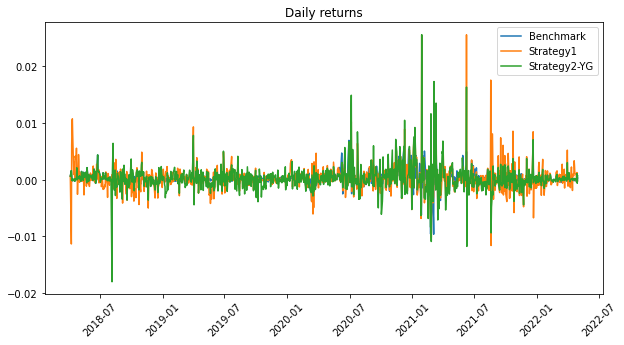

In [165]:
# daily returns
plt.figure(figsize=(10,5))
plt.plot(compar3['date'],compar3['bp_dret'],label='Benchmark')
plt.plot(compar3['date'],compar3['p1_dret'],label='Strategy1')
plt.plot(compar3['date'],compar3['p3_dret'],label='Strategy2-YG')
plt.xticks(rotation=45)
plt.title('Daily returns')
plt.legend()
plt.show()

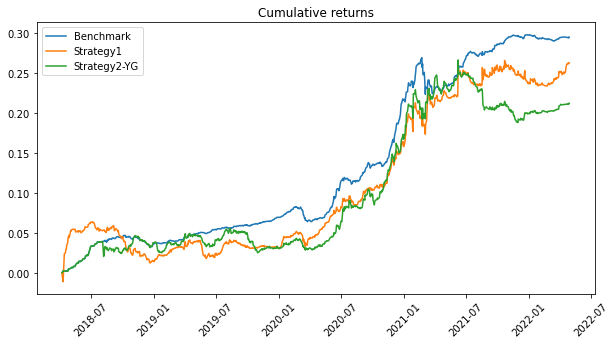

In [166]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar3['date'],compar3['bp_cumret'],label='Benchmark')
plt.plot(compar3['date'],compar3['p1_cumret'],label='Strategy1')
plt.plot(compar3['date'],compar3['p3_cumret'],label='Strategy2-YG')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

In [167]:
# annualized return
p3_anret = pow(1 + compar3['p3_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p1_anret,p3_anret)

0.06551816836285207 0.058938403357429836 0.04841082964290333


In [168]:
# annualized volatility
p3_anvol = compar3['p3_dret'].std()*np.sqrt(250)
print(bp_anvol,p1_anvol,p3_anvol)

0.01950668582119034 0.03830443354166091 0.03617014644872355


In [169]:
# sharpe ratio
p3_SR = (p3_anret - last_rf) / p3_anvol
print(bp_SR,p1_SR,p3_SR)

1.8772111622915115 0.7842017380249019 0.5394180438434987


#### monthly growth rate

In [170]:
mg_signal = spac_mv_m[['date','MonthGrowth','MG_hist_mean']].dropna().reset_index(drop=True)

In [171]:
mg_signal['signal'] = (mg_signal['MonthGrowth'] > mg_signal['MG_hist_mean']).shift(1).fillna(False)
mg_signal

,date,MonthGrowth,MG_hist_mean,signal
0,2017-02-28,0.093784,0.085151,False
1,2017-03-31,-0.112769,0.098633,True
2,2017-04-28,0.142621,0.112897,False
3,2017-05-31,-0.055887,0.144262,True
4,2017-06-30,0.120076,0.124803,False
...,...,...,...,...
57,2021-12-31,-0.035113,0.100089,False
58,2022-01-31,-0.051482,0.093846,False
59,2022-02-28,-0.036792,0.068032,False
60,2022-03-31,0.059115,0.067039,False


In [172]:
# create portfolio
port4 = pd.DataFrame(period)
port4.columns = ['date']
port4['port_value'] = 0
port4['last_value'] = 0 # record the value of warrants at the last day
port4['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port4['last_value_unit'] = 0 # record the value of units at the last day
port4['tcost'] = 0 # transaction cost (assuming 10% per share)
port4['turnover'] = 0 # trading volume in shares
port4['reb_day'] = np.nan
port4.reb_day[port4.date.isin(reb_freq)] = 1

In [173]:
p4 = strategy2(u,d,m,h,tc,cap,port4,price_reb,mg_signal)

In [174]:
p4.turnover.mean()

236.42144873000942

In [175]:
p4ret = p4.copy()
p4ret[['last_value','last_value_unit']] = p4ret[['last_value','last_value_unit']].shift(1).fillna(0)
p4ret['daily_ret'] = (p4ret['port_value'].diff()+p4ret['last_value'])/(p4ret['unit_value'].shift(1)-p4ret['last_value_unit'])
p4ret = p4ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p4ret['pct_tcost'] = p4ret['tcost']/p4ret['unit_value']
p4ret['daily_ret'] = p4ret['daily_ret'] - p4ret['pct_tcost']

In [176]:
compar4 = compar3.copy()
compar4 = compar4.merge(p4ret[['date','daily_ret']],on=['date'],how='inner')
compar4 = compar4.rename(columns={'daily_ret':'p4_dret'})
compar4['p4_cumret'] = (compar4.p4_dret + 1).cumprod() - 1

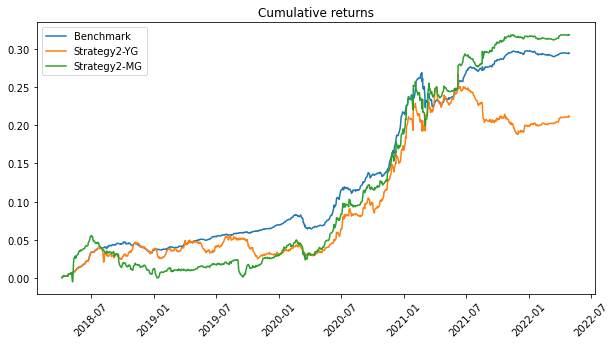

In [177]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar4['date'],compar4['bp_cumret'],label='Benchmark')
# plt.plot(compar4['date'],compar4['p1_cumret'],label='Strategy1')
plt.plot(compar4['date'],compar4['p3_cumret'],label='Strategy2-YG')
plt.plot(compar4['date'],compar4['p4_cumret'],label='Strategy2-MG')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

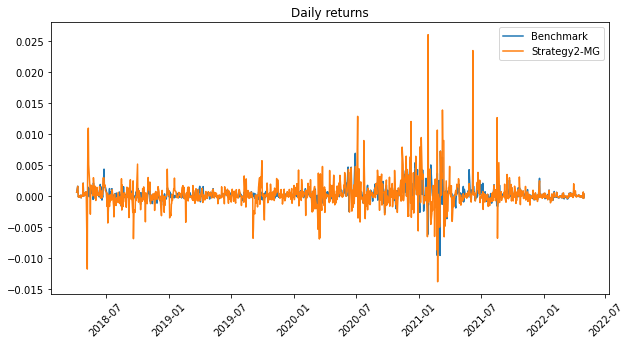

In [178]:
# daily returns
plt.figure(figsize=(10,5))
plt.plot(compar4['date'],compar4['bp_dret'],label='Benchmark')
# plt.plot(compar4['date'],compar4['p1_dret'],label='Strategy1')
plt.plot(compar4['date'],compar4['p4_dret'],label='Strategy2-MG')
plt.xticks(rotation=45)
plt.title('Daily returns')
plt.legend()
plt.show()

In [179]:
# max drawdown
compar4['p4_dret'].min()

-0.013857704387082675

In [180]:
# annualized return
p4_anret = pow(1 + compar4['p4_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p3_anret,p4_anret)

0.06551816836285207 0.04841082964290333 0.07034082260918617


In [181]:
# annualized volatility
p4_anvol = compar4['p4_dret'].std()*np.sqrt(250)
print(bp_anvol,p3_anvol,p4_anvol)

0.01950668582119034 0.03617014644872355 0.03712719088263974


In [182]:
# sharpe ratio
p4_SR = (p4_anret - last_rf) / p4_anvol
print(bp_SR,p3_SR,p4_SR)

1.8772111622915115 0.5394180438434987 1.1161852438602735


#### successful SPAC amount

In [183]:
suc_signal = suc_spac_m[['date','number','suc_hist_mean']].dropna().reset_index(drop=True)

In [184]:
suc_signal['signal'] = (suc_signal['number'] > suc_signal['suc_hist_mean']).shift(1).fillna(False)

In [185]:
suc_signal

,date,number,suc_hist_mean,signal
0,2018-06-30,1,2.000000,False
1,2018-07-31,3,1.916667,False
2,2018-08-31,2,2.000000,True
3,2018-10-31,2,2.000000,False
4,2018-11-30,5,2.083333,False
5,2018-12-31,4,2.333333,True
6,2019-01-31,1,2.333333,True
7,2019-02-28,1,2.333333,False
8,2019-03-31,4,2.333333,False
9,2019-04-30,2,2.500000,True


In [186]:
# create portfolio
port5 = pd.DataFrame(period)
port5.columns = ['date']
port5['port_value'] = 0
port5['last_value'] = 0 # record the value of warrants at the last day
port5['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port5['last_value_unit'] = 0 # record the value of units at the last day
port5['tcost'] = 0 # transaction cost (assuming 10% per share)
port5['turnover'] = 0 # trading volume in shares
port5['reb_day'] = np.nan
port5.reb_day[port5.date.isin(reb_freq)] = 1

In [187]:
p5 = strategy2(u,d,m,h,tc,cap,port5,price_reb,suc_signal)

In [188]:
p5

,date,port_value,last_value,unit_value,last_value_unit,tcost,turnover,reb_day,signal
0,2018-04-04,0.0000,0.0000,0.000000,0.0000,0.000000,0.0,0.0,False
1,2018-04-05,2354.9851,0.0000,67686.467100,0.0000,117.749255,4154.0,0.0,False
2,2018-04-06,2400.9558,0.0000,68848.247800,0.0000,4.969545,133.0,0.0,False
3,2018-04-09,2514.2855,0.0000,69875.612500,0.0000,4.872000,112.0,0.0,False
4,2018-04-10,2569.8312,0.0000,70066.073200,0.0000,0.000000,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...
1058,2022-04-25,5270.0192,0.0000,358286.427200,0.0000,5.365000,370.0,1.0,False
1059,2022-04-26,5130.8457,0.0000,358183.129000,0.0000,0.000000,0.0,1.0,False
1060,2022-04-27,5680.4233,0.0000,405763.689967,0.0000,31.828665,2336.0,1.0,False
1061,2022-04-28,5362.1953,89.2164,404936.389533,3525.3764,0.000000,0.0,1.0,False


In [189]:
p5ret = p5.copy()
p5ret[['last_value','last_value_unit']] = p5ret[['last_value','last_value_unit']].shift(1).fillna(0)
p5ret['daily_ret'] = (p5ret['port_value'].diff()+p5ret['last_value'])/(p5ret['unit_value'].shift(1)-p5ret['last_value_unit'])
p5ret = p5ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p5ret['pct_tcost'] = p5ret['tcost']/p5ret['unit_value']
p5ret['daily_ret'] = p5ret['daily_ret'] - p5ret['pct_tcost']

In [190]:
compar5 = compar4.copy()
compar5 = compar5.merge(p5ret[['date','daily_ret']],on=['date'],how='inner')
compar5 = compar5.rename(columns={'daily_ret':'p5_dret'})
compar5['p5_cumret'] = (compar5.p5_dret + 1).cumprod() - 1

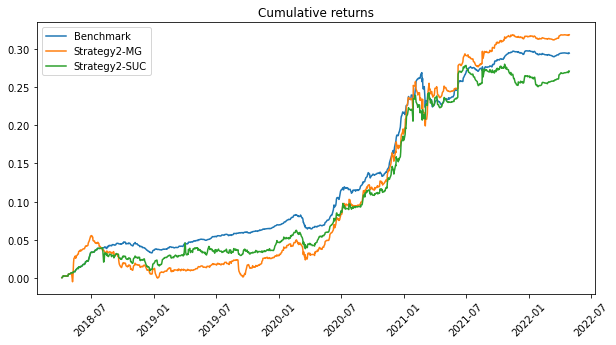

In [191]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar5['date'],compar5['bp_cumret'],label='Benchmark')
plt.plot(compar5['date'],compar5['p4_cumret'],label='Strategy2-MG')
plt.plot(compar5['date'],compar5['p5_cumret'],label='Strategy2-SUC')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

In [192]:
# annualized return
p5_anret = pow(1 + compar5['p5_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p4_anret,p5_anret)

0.06551816836285207 0.07034082260918617 0.060716844865402964


In [193]:
# annualized volatility
p5_anvol = compar5['p5_dret'].std()*np.sqrt(250)
print(bp_anvol,p4_anvol,p5_anvol)

0.01950668582119034 0.03712719088263974 0.037029528627371425


In [194]:
# sharpe ratio
p5_SR = (p5_anret - last_rf) / p5_anvol
print(bp_SR,p4_SR,p5_SR)

1.8772111622915115 1.1161852438602735 0.8592290003358195


#### successful ratio 

In [195]:
sucr_signal = suc_spac_m[['date','ratio','ratio_ma']].dropna().reset_index(drop=True)

In [196]:
sucr_signal['signal'] = (sucr_signal['ratio'] > sucr_signal['ratio_ma']).shift(1).fillna(False)
sucr_signal

,date,ratio,ratio_ma,signal
0,2018-07-31,0.042254,0.042194,False
1,2018-08-31,0.027397,0.041211,True
2,2018-10-31,0.025000,0.039429,False
3,2018-11-30,0.062500,0.039375,False
4,2018-12-31,0.047619,0.040310,True
5,2019-01-31,0.011364,0.037032,True
6,2019-02-28,0.011236,0.036127,False
7,2019-03-31,0.043478,0.035290,False
8,2019-04-30,0.021978,0.035937,True
9,2019-05-31,0.040000,0.036307,False


In [197]:
# create portfolio
port6 = pd.DataFrame(period)
port6.columns = ['date']
port6['port_value'] = 0
port6['last_value'] = 0 # record the value of warrants at the last day
port6['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port6['last_value_unit'] = 0 # record the value of units at the last day
port6['tcost'] = 0 # transaction cost (assuming 10% per share)
port6['turnover'] = 0 # trading volume in shares
port6['reb_day'] = np.nan
port6.reb_day[port6.date.isin(reb_freq)] = 1

In [198]:
p6 = strategy2(u,d,m,h,tc,cap,port6,price_reb,sucr_signal)

In [199]:
p6

,date,port_value,last_value,unit_value,last_value_unit,tcost,turnover,reb_day,signal
0,2018-04-04,0.0000,0.0000,0.000000,0.0000,0.000000,0.0,0.0,False
1,2018-04-05,2354.9851,0.0000,67686.467100,0.0000,117.749255,4154.0,0.0,False
2,2018-04-06,2400.9558,0.0000,68848.247800,0.0000,4.969545,133.0,0.0,False
3,2018-04-09,2514.2855,0.0000,69875.612500,0.0000,4.872000,112.0,0.0,False
4,2018-04-10,2569.8312,0.0000,70066.073200,0.0000,0.000000,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...
1058,2022-04-25,5350.8063,0.0000,365776.684300,0.0000,5.365000,370.0,1.0,False
1059,2022-04-26,5210.3451,0.0000,365664.363400,0.0000,0.000000,0.0,1.0,False
1060,2022-04-27,5752.7984,0.0000,413241.530067,0.0000,31.828665,2336.0,1.0,False
1061,2022-04-28,5429.5917,89.2164,412405.410933,3525.3764,0.000000,0.0,1.0,False


In [200]:
p6.turnover.mean()

295.19379115710257

In [201]:
p6ret = p6.copy()
p6ret[['last_value','last_value_unit']] = p6ret[['last_value','last_value_unit']].shift(1).fillna(0)
p6ret['daily_ret'] = (p6ret['port_value'].diff()+p6ret['last_value'])/(p6ret['unit_value'].shift(1)-p6ret['last_value_unit'])
p6ret = p6ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p6ret['pct_tcost'] = p6ret['tcost']/p6ret['unit_value']
p6ret['daily_ret'] = p6ret['daily_ret'] - p6ret['pct_tcost']

In [202]:
compar6 = compar5.copy()
compar6 = compar6.merge(p6ret[['date','daily_ret']],on=['date'],how='inner')
compar6 = compar6.rename(columns={'daily_ret':'p6_dret'})
compar6['p6_cumret'] = (compar6.p6_dret + 1).cumprod() - 1

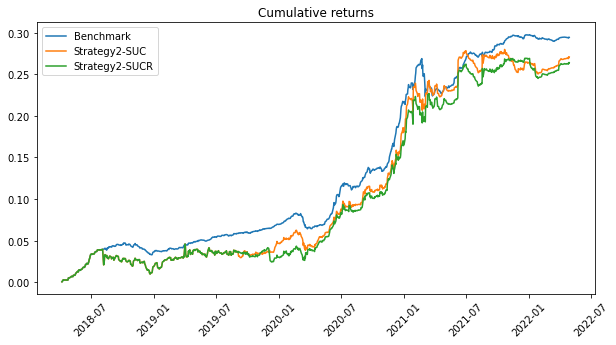

In [203]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar6['date'],compar6['bp_cumret'],label='Benchmark')
# plt.plot(compar6['date'],compar6['p1_cumret'],label='Strategy1')
# plt.plot(compar6['date'],compar6['p3_cumret'],label='Strategy2-YG')
# plt.plot(compar6['date'],compar6['p4_cumret'],label='Strategy2-MG')
plt.plot(compar6['date'],compar6['p5_cumret'],label='Strategy2-SUC')
plt.plot(compar6['date'],compar6['p6_cumret'],label='Strategy2-SUCR')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

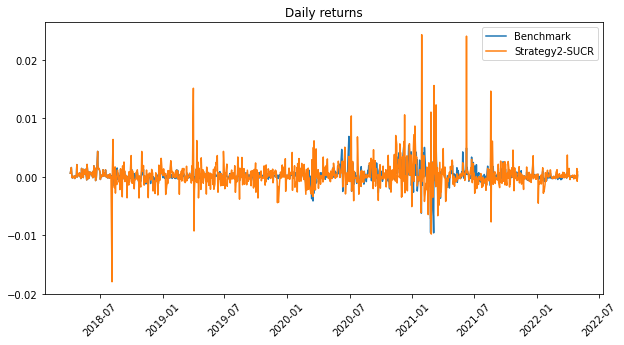

In [204]:
# daily returns
plt.figure(figsize=(10,5))
plt.plot(compar6['date'],compar6['bp_dret'],label='Benchmark')
plt.plot(compar6['date'],compar6['p6_dret'],label='Strategy2-SUCR')
plt.xticks(rotation=45)
plt.title('Daily returns')
plt.legend()
plt.show()

In [205]:
# annualized return
p6_anret = pow(1 + compar6['p6_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p4_anret,p6_anret)

0.06551816836285207 0.07034082260918617 0.05932741157997645


In [206]:
# annualized volatility
p6_anvol = compar6['p6_dret'].std()*np.sqrt(250)
print(bp_anvol,p4_anvol,p6_anvol)

0.01950668582119034 0.03712719088263974 0.03667261699379131


In [207]:
# sharpe ratio
p6_SR = (p6_anret - last_rf) / p6_anvol
print(bp_SR,p4_SR,p6_SR)

1.8772111622915115 1.1161852438602735 0.8297038519265703


## Strategy 3

### Buy-and-hold before the deal complete, rebalance after the deal complete when the market is hot, use moving average pct_diff as signal.

In [208]:
price_reb

,spac_id,date,mkt_p,equity,rights,wpu,epu,rpu,units,mdl_p,p_diff,pct_diff,pct_diff_ma
0,1,2018-11-16,0.360,9.64,0.39,1.0,1,1.0,10.3900,0.059826,-0.300174,-0.833816,0.0
1,1,2018-11-19,0.350,9.66,0.33,1.0,1,1.0,10.3400,0.061794,-0.288206,-0.823446,0.0
2,1,2018-11-20,0.320,9.72,0.34,1.0,1,1.0,10.3800,0.072768,-0.247232,-0.772601,0.0
3,1,2018-11-21,0.320,9.73,0.33,1.0,1,1.0,10.3800,0.083718,-0.236282,-0.738383,0.0
4,1,2018-11-23,0.320,9.75,0.33,1.0,1,1.0,10.4000,0.085615,-0.234385,-0.732454,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83859,1435,2022-04-29,0.311,9.95,0.00,0.5,1,0.0,10.1055,0.136353,-0.174647,-0.561566,0.0
83860,1459,2022-04-26,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.114322,-0.245678,-0.682439,0.0
83861,1459,2022-04-27,0.360,9.93,0.00,0.5,1,0.0,10.1100,0.120065,-0.239935,-0.666487,0.0
83862,1459,2022-04-28,0.340,9.93,0.00,0.5,1,0.0,10.1000,0.123495,-0.216505,-0.636778,0.0


In [209]:
suc_spac

,spac_id,code,reported_date,effective_date,trust_date,trust_per_share,shares_outstanding,state_type_id,year,month
0,2,COMPLETE,2018-08-23,2018-08-23,NaT,NaN,NaN,5.0,2018,8
1,3,COMPLETE,2018-12-10,2018-12-10,NaT,NaN,NaN,5.0,2018,12
2,5,COMPLETE,2021-05-25,2021-05-25,NaT,NaN,NaN,5.0,2021,5
3,6,COMPLETE,2019-05-14,2019-05-14,NaT,NaN,NaN,5.0,2019,5
4,7,COMPLETE,2019-08-12,2019-08-12,NaT,NaN,NaN,5.0,2019,8
...,...,...,...,...,...,...,...,...,...,...
512,1000,COMPLETE,2021-12-17,2021-12-17,NaT,NaN,NaN,5.0,2021,12
513,1053,COMPLETE,2022-04-23,2022-04-25,NaT,NaN,NaN,5.0,2022,4
514,1054,COMPLETE,2021-12-28,2021-12-28,NaT,NaN,NaN,5.0,2021,12
515,1074,COMPLETE,2021-12-01,2021-12-07,NaT,NaN,NaN,5.0,2021,12


In [210]:
def strategy3(u,d,m,h,tc,cap,port,price_reb,mkt_signal):
    
    for i in all_id:

        sub_price = price_reb[price_reb.spac_id==i]
        
        # rebalance day
        port['reb_day'] = np.nan
        if (suc_spac.spac_id==i).sum()>0:
            port.reb_day[port.date.isin(reb_freq)] = 1
            complete_day = suc_spac[suc_spac.spac_id==i].effective_date.iloc[0]
            port.reb_day[port.date<complete_day] = np.nan
            
        # only keep rebalance days when the signal is True
        port['y'] = port.date.dt.year
        port['m'] = port.date.dt.month
        mkt_signal['y'] = mkt_signal.date.dt.year
        mkt_signal['m'] = mkt_signal.date.dt.month
        port = port.merge(mkt_signal[['y','m','signal']],on=['y','m'],how='left')
        port['signal'] = port['signal'].ffill().fillna(False)
        port['reb_day'][~port['signal']] = np.nan
        port = port.drop(['y','m'],axis=1)

        # buy $cap warrant at its first close price 
        unit = (cap/sub_price.mkt_p.values[0]).round()

        # merge market prices & percentage difference
        port = port.merge(sub_price[['date','mkt_p','pct_diff_ma','units','wpu']], on='date', how='left')
        inrange_date = (port.date>=sub_price.date.iloc[0])&(port.date<=sub_price.date.iloc[-1])
        port.pct_diff_ma[inrange_date] = port[inrange_date].pct_diff_ma.fillna(0)
        port[inrange_date] = port[inrange_date].ffill()

        # the original shares of warrant
        port['share'] = np.nan
        port.share[inrange_date] = unit
        port.share[inrange_date] = port[inrange_date].share.shift(1)

        # adjust shares weekly during rebalancing periods
        reb_period = port.signal&inrange_date
        port['adj_share'] = np.nan
        if port[reb_period].share.notna().sum()>1:
            adjust = 1+port.pct_diff_ma[reb_period]*h
            adjust = np.where(adjust>u,u,adjust) # limit for daily shares increase
            adjust = np.where(adjust<d,d,adjust) # limit for daily shares decrease
            new_share = (port.share[reb_period] * adjust.cumprod() * port.reb_day[reb_period]).round()
            new_share = np.where(new_share>m*unit,m*unit,new_share) # upper limit for total holding shares
            new_share = np.where(new_share<1,0,new_share)
            port['adj_share'][reb_period] = new_share
            port['adj_share'][inrange_date] = port[inrange_date]['adj_share'].ffill()
        port['adj_share'][inrange_date] = port[inrange_date]['adj_share'].fillna(unit).shift(1)

        # update portfolio value
        port[['mkt_p','adj_share']] = port[['mkt_p','adj_share']].fillna(0)
        port.port_value = (port.port_value + port.mkt_p*port.adj_share)
        
        # update unit portfolio value
        port.unit_value = port.unit_value + ((port.adj_share/port.wpu)*port.units).fillna(0)
        
        # update the last day value
        last_day = port.index[inrange_date][-1]
        port.loc[last_day,'last_value'] = port.loc[last_day,'last_value'] +\
                                          port.loc[last_day,'mkt_p']*port.loc[last_day,'adj_share']
        port.loc[last_day,'last_value_unit'] = (port.loc[last_day,'last_value_unit'] +
                                                port.loc[last_day,'units']*
                                                port.loc[last_day,'adj_share']/port.loc[last_day,'wpu'])
        
        # update transaction cost
        trad_vol = abs(port.adj_share.diff().fillna(0))
        port.tcost = port.tcost + trad_vol*port.mkt_p*tc
        
        # update trading volume
        port.turnover = port.turnover + trad_vol
        
        port = port.drop(['mkt_p','pct_diff_ma','share','adj_share','reb_day','signal','units','wpu'],axis=1)

    port = port.fillna(0)
    
    return port

In [211]:
# create portfolio
port7 = pd.DataFrame(period)
port7.columns = ['date']
port7['port_value'] = 0
port7['last_value'] = 0 # record the value of warrants at the last day
port7['unit_value'] = 0 # value of the whole unit portfolio (equity+warrant+rights)
port7['last_value_unit'] = 0 # record the value of units at the last day
port7['tcost'] = 0 # transaction cost (assuming 10% per share)
port7['turnover'] = 0 # trading volume in shares

In [212]:
p7 = strategy3(u,d,m,h,tc,cap,port7,price_reb,sucr_signal)

In [213]:
p7ret = p7.copy()
p7ret[['last_value','last_value_unit']] = p7ret[['last_value','last_value_unit']].shift(1).fillna(0)
p7ret['daily_ret'] = (p7ret['port_value'].diff()+p7ret['last_value'])/(p7ret['unit_value'].shift(1)-p7ret['last_value_unit'])
p7ret = p7ret.drop([0,1]).reset_index(drop=True)

# embed trading cost
p7ret['pct_tcost'] = p7ret['tcost']/p7ret['unit_value']
p7ret['daily_ret'] = p7ret['daily_ret'] - p7ret['pct_tcost']

In [214]:
compar7 = compar6.copy()
compar7 = compar7.merge(p7ret[['date','daily_ret']],on=['date'],how='inner')
compar7 = compar7.rename(columns={'daily_ret':'p7_dret'})
compar7['p7_cumret'] = (compar7.p7_dret + 1).cumprod() - 1

In [215]:
compar7.p7_dret.min()

-0.012508947528378308

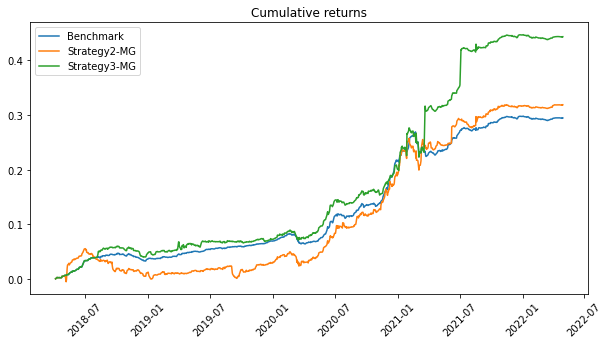

In [222]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar7['date'],compar7['bp_cumret'],label='Benchmark')
plt.plot(compar7['date'],compar7['p4_cumret'],label='Strategy2-MG')
plt.plot(compar7['date'],compar7['p7_cumret'],label='Strategy3-MG')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

In [223]:
# annualized return
p7_anret = pow(1 + compar7['p7_cumret'].iloc[-1],1/yr) - 1
print(bp_anret,p4_anret,p7_anret)

0.06551816836285207 0.07034082260918617 0.0943243040351327


In [224]:
# annualized volatility
p7_anvol = compar7['p7_dret'].std()*np.sqrt(250)
print(bp_anvol,p4_anvol,p7_anvol)

0.01950668582119034 0.03712719088263974 0.05086434845973531


In [225]:
# max drawdown
compar7.p7_dret.min()

-0.012508947528378308

In [226]:
p7.turnover.mean()

218.53998118532456

In [227]:
# turnover
p4.turnover.mean()

236.42144873000942

In [228]:
# sharpe ratio
p7_SR = (p7_anret - last_rf) / p7_anvol
print(bp_SR,p4_SR,p7_SR)

1.8772111622915115 1.1161852438602735 1.2862507043990385


## Performance 

### 1) Break out the performance (before 2020 and after 2020)

In [229]:
compar7_b2020 = compar7[compar7.date.dt.year<2020].reset_index(drop=True)
compar7_a2020 = compar7[compar7.date.dt.year>=2020].reset_index(drop=True)

In [230]:
# before 2020
pf_b2020 = pd.DataFrame(columns=['Benchmark','Strategy1','Strategy2_MG','Strategy3_MG'],
                                index=['an_ret','an_vol','SR','max_drawdown','ave_turnover'])

In [231]:
b2020_yr = (compar7_b2020.date.max() - compar7_b2020.date.min()).days/365

In [232]:
last_rf_b2020 = compar7_b2020.rf_rate.iloc[-1]

In [233]:
pf_b2020.loc['an_ret','Benchmark'] = pow(1 + compar7_b2020['bp_cumret'].iloc[-1],1/b2020_yr) - 1
pf_b2020.loc['an_ret','Strategy1'] = pow(1 + compar7_b2020['p1_cumret'].iloc[-1],1/b2020_yr) - 1
pf_b2020.loc['an_ret','Strategy2_MG'] = pow(1 + compar7_b2020['p4_cumret'].iloc[-1],1/b2020_yr) - 1
pf_b2020.loc['an_ret','Strategy3_MG'] = pow(1 + compar7_b2020['p7_cumret'].iloc[-1],1/b2020_yr) - 1

In [234]:
pf_b2020.loc['an_vol','Benchmark'] = compar7_b2020['bp_dret'].std()*np.sqrt(250)
pf_b2020.loc['an_vol','Strategy1'] = compar7_b2020['p1_dret'].std()*np.sqrt(250)
pf_b2020.loc['an_vol','Strategy2_MG'] = compar7_b2020['p4_dret'].std()*np.sqrt(250)
pf_b2020.loc['an_vol','Strategy3_MG'] = compar7_b2020['p7_dret'].std()*np.sqrt(250)

In [235]:
pf_b2020.loc['SR','Benchmark'] = (pf_b2020.loc['an_ret','Benchmark'] - 
                                  last_rf_b2020) / pf_b2020.loc['an_vol','Benchmark']
pf_b2020.loc['SR','Strategy1'] = (pf_b2020.loc['an_ret','Strategy1'] - 
                                  last_rf_b2020) / pf_b2020.loc['an_vol','Strategy1']
pf_b2020.loc['SR','Strategy2_MG'] = (pf_b2020.loc['an_ret','Strategy2_MG'] - 
                                     last_rf_b2020) / pf_b2020.loc['an_vol','Strategy2_MG']
pf_b2020.loc['SR','Strategy3_MG'] = (pf_b2020.loc['an_ret','Strategy3_MG'] - 
                                     last_rf_b2020) / pf_b2020.loc['an_vol','Strategy3_MG']

In [236]:
pf_b2020.loc['max_drawdown','Benchmark'] = compar7_b2020.bp_dret.min()
pf_b2020.loc['max_drawdown','Strategy1'] = compar7_b2020.p1_dret.min()
pf_b2020.loc['max_drawdown','Strategy2_MG'] = compar7_b2020.p4_dret.min()
pf_b2020.loc['max_drawdown','Strategy3_MG'] = compar7_b2020.p7_dret.min()

In [237]:
pf_b2020.loc['ave_turnover','Benchmark'] = bport[bport.date.dt.year<2020].turnover.mean()
pf_b2020.loc['ave_turnover','Strategy1'] = p1[p1.date.dt.year<2020].turnover.mean()
pf_b2020.loc['ave_turnover','Strategy2_MG'] = p4[p4.date.dt.year<2020].turnover.mean()
pf_b2020.loc['ave_turnover','Strategy3_MG'] = p7[p7.date.dt.year<2020].turnover.mean()

In [238]:
# after 2020
pf_a2020 = pd.DataFrame(columns=['Benchmark','Strategy1','Strategy2_MG','Strategy3_MG'],
                                index=['an_ret','an_vol','SR','max_drawdown','ave_turnover'])

In [239]:
a2020_yr = (compar7_a2020.date.max() - compar7_a2020.date.min()).days/365

In [240]:
pf_a2020.loc['an_ret','Benchmark'] = pow((1 + compar7_a2020['bp_cumret'].iloc[-1])/
                                         (1+compar7_a2020['bp_cumret'].iloc[0]),1/a2020_yr) - 1
pf_a2020.loc['an_ret','Strategy1'] = pow((1 + compar7_a2020['p1_cumret'].iloc[-1])/
                                         (1+compar7_a2020['p1_cumret'].iloc[0]),1/a2020_yr) - 1
pf_a2020.loc['an_ret','Strategy2_MG'] = pow((1 + compar7_a2020['p4_cumret'].iloc[-1])/
                                            (1+compar7_a2020['p4_cumret'].iloc[0]),1/a2020_yr) - 1
pf_a2020.loc['an_ret','Strategy3_MG'] = pow((1 + compar7_a2020['p7_cumret'].iloc[-1])/
                                            (1+compar7_a2020['p7_cumret'].iloc[0]),1/a2020_yr) - 1

In [241]:
pf_a2020.loc['an_vol','Benchmark'] = compar7_a2020['bp_dret'].std()*np.sqrt(250)
pf_a2020.loc['an_vol','Strategy1'] = compar7_a2020['p1_dret'].std()*np.sqrt(250)
pf_a2020.loc['an_vol','Strategy2_MG'] = compar7_a2020['p4_dret'].std()*np.sqrt(250)
pf_a2020.loc['an_vol','Strategy3_MG'] = compar7_a2020['p7_dret'].std()*np.sqrt(250)

In [242]:
pf_a2020.loc['SR','Benchmark'] = (pf_a2020.loc['an_ret','Benchmark'] - 
                                  last_rf) / pf_a2020.loc['an_vol','Benchmark']
pf_a2020.loc['SR','Strategy1'] = (pf_a2020.loc['an_ret','Strategy1'] - 
                                  last_rf) / pf_a2020.loc['an_vol','Strategy1']
pf_a2020.loc['SR','Strategy2_MG'] = (pf_a2020.loc['an_ret','Strategy2_MG'] - 
                                     last_rf) / pf_a2020.loc['an_vol','Strategy2_MG']
pf_a2020.loc['SR','Strategy3_MG'] = (pf_a2020.loc['an_ret','Strategy3_MG'] - 
                                     last_rf) / pf_a2020.loc['an_vol','Strategy3_MG']

In [243]:
pf_a2020.loc['max_drawdown','Benchmark'] = compar7_a2020.bp_dret.min()
pf_a2020.loc['max_drawdown','Strategy1'] = compar7_a2020.p1_dret.min()
pf_a2020.loc['max_drawdown','Strategy2_MG'] = compar7_a2020.p4_dret.min()
pf_a2020.loc['max_drawdown','Strategy3_MG'] = compar7_a2020.p7_dret.min()

In [244]:
pf_a2020.loc['ave_turnover','Benchmark'] = bport[bport.date.dt.year>=2020].turnover.mean()
pf_a2020.loc['ave_turnover','Strategy1'] = p1[p1.date.dt.year>=2020].turnover.mean()
pf_a2020.loc['ave_turnover','Strategy2_MG'] = p4[p4.date.dt.year>=2020].turnover.mean()
pf_a2020.loc['ave_turnover','Strategy3_MG'] = p7[p7.date.dt.year>=2020].turnover.mean()

In [245]:
pf_b2020

,Benchmark,Strategy1,Strategy2_MG,Strategy3_MG
an_ret,0.039424,0.01765,0.016842,0.041354
an_vol,0.008773,0.027391,0.025437,0.019794
SR,2.305365,-0.056581,-0.092715,1.119225
max_drawdown,-0.001584,-0.011319,-0.011807,-0.006939
ave_turnover,55.017582,302.116484,155.248352,132.054945


In [246]:
pf_a2020

,Benchmark,Strategy1,Strategy2_MG,Strategy3_MG
an_ret,0.085512,0.090972,0.112209,0.135751
an_vol,0.024581,0.044675,0.043733,0.064915
SR,2.303106,1.389422,1.904937,1.646022
max_drawdown,-0.009604,-0.01159,-0.013858,-0.012509
ave_turnover,161.46875,528.555921,297.167763,283.261513


### 2) Overall performance (04/2018-04/2022)

In [247]:
pf = pd.DataFrame(columns=['Benchmark','Strategy1','Strategy2_MG','Strategy3_MG'],
                  index=['an_ret','an_vol','SR','max_drawdown','ave_turnover'])

In [248]:
pf.loc['an_ret','Benchmark'] = bp_anret
pf.loc['an_ret','Strategy1'] = p1_anret
pf.loc['an_ret','Strategy2_MG'] = p4_anret
pf.loc['an_ret','Strategy3_MG'] = p7_anret

In [249]:
pf.loc['an_vol','Benchmark'] = bp_anvol
pf.loc['an_vol','Strategy1'] = p1_anvol
pf.loc['an_vol','Strategy2_MG'] = p4_anvol
pf.loc['an_vol','Strategy3_MG'] = p7_anvol

In [250]:
pf.loc['SR','Benchmark'] = bp_SR
pf.loc['SR','Strategy1'] = p1_SR
pf.loc['SR','Strategy2_MG'] = p4_SR
pf.loc['SR','Strategy3_MG'] = p7_SR

In [251]:
pf.loc['max_drawdown','Benchmark'] = compar7.bp_dret.min()
pf.loc['max_drawdown','Strategy1'] = compar7.p1_dret.min()
pf.loc['max_drawdown','Strategy2_MG'] = compar7.p4_dret.min()
pf.loc['max_drawdown','Strategy3_MG'] = compar7.p7_dret.min()

In [252]:
pf.loc['ave_turnover','Benchmark'] = bport.turnover.mean()
pf.loc['ave_turnover','Strategy1'] = p1.turnover.mean()
pf.loc['ave_turnover','Strategy2_MG'] = p4.turnover.mean()
pf.loc['ave_turnover','Strategy3_MG'] = p7.turnover.mean()

In [253]:
pf

,Benchmark,Strategy1,Strategy2_MG,Strategy3_MG
an_ret,0.065518,0.058938,0.070341,0.094324
an_vol,0.019507,0.038304,0.037127,0.050864
SR,1.877211,0.784202,1.116185,1.286251
max_drawdown,-0.009604,-0.01159,-0.013858,-0.012509
ave_turnover,115.904045,431.632173,236.421449,218.539981


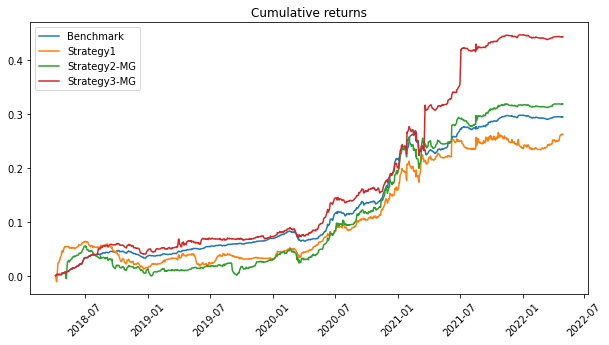

In [254]:
# cumulative returns
plt.figure(figsize=(10,5))
plt.plot(compar7['date'],compar7['bp_cumret'],label='Benchmark')
plt.plot(compar7['date'],compar7['p1_cumret'],label='Strategy1')
plt.plot(compar7['date'],compar7['p4_cumret'],label='Strategy2-MG')
plt.plot(compar7['date'],compar7['p7_cumret'],label='Strategy3-MG')
plt.xticks(rotation=45)
plt.title('Cumulative returns')
plt.legend()
plt.show()

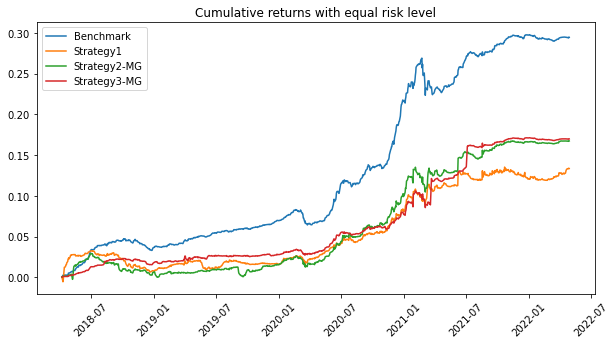

In [256]:
# make them have the same volatility
plt.figure(figsize=(10,5))
plt.plot(compar7['date'],compar7['bp_cumret'],label='Benchmark')
plt.plot(compar7['date'],compar7['p1_cumret']*bp_anvol/p1_anvol,label='Strategy1')
plt.plot(compar7['date'],compar7['p4_cumret']*bp_anvol/p4_anvol,label='Strategy2-MG')
plt.plot(compar7['date'],compar7['p7_cumret']*bp_anvol/p7_anvol,label='Strategy3-MG')
plt.xticks(rotation=45)
plt.title('Cumulative returns with equal risk level')
plt.legend()
plt.show()